## Кейс 10 - Бинарная классификация перекрёстных продаж страхования

### Команда "Страховщики":

- Мартынов Дмитрий
- Осипов Роман
- Иванков Дмитрий
- Плахотин Андрей
- Тайсумова Луиза

### Содержание

1. [Исследовательский анализ](#eda)
  - 1.1. [Общая информация о данных](#eda-general)
  - 1.2. [Анализ целевой переменной](#eda-target)
  - 1.3. [Распределения](#eda-distribution)
  - 1.4. [Аномалии](#eda-anomaly)
  - 1.5. [Корреляции](#eda-correlation)
  - 1.6. [Анализ взаимосвязей](#eda-relations)
  - 1.7. [Feature Engineering](#eda-fe)
  - 1.8. [Стратегия предобработки](#eda-preprocessing)

---

2. [Методология и Валидация](#methodology)
  - 2.1. [Метрики качества](#methodology-metrics)
  - 2.2. [Схема валидации](#methodology-val)

---

3. [Моделирование и Оптимизация](#model)
  - 3.1. [Функции-утилиты](#model-utils)
  - 3.2. [Baseline модель](#model-baseline)
  - 3.3. [Тестирование и сравнение моделей](#model-compare)
  - 3.4. [Продвинутая гипероптимизация](#model-optimize)
  - 3.5. [Анализ компромисса “Качество vs. Сложность”](#model-compare-time)
    - 3.5.1. [Feature Importance](#model-fi)


## Установка необходимых зависимостей

In [101]:
!pip install -q numpy pandas matplotlib seaborn scikit-learn lightgbm catboost optuna phik klib tabulate joblib category-encoders requests shap

## Импорт библиотек

In [102]:
# Основные библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import gc
import shap
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

# Машинное обучение - scikit-learn
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
    GridSearchCV,
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, RobustScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import (
    get_scorer, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)

# Дополнительные ML библиотеки
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Специальные библиотеки
from phik.report import plot_correlation_matrix
import klib as kl
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner

# Настройки отображения
sns.set_style("whitegrid")

## Определение констант

In [3]:
TARGET_NAME = 'Response'
FILE_PATH = 'https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv'
CV_FOLDS = 2
RANDOM_STATE = 42
N_JOBS = -1

Загрузка датасета

In [4]:
df = pd.read_csv(FILE_PATH, index_col='id')

<a id="eda"></a>
# 1. Исследовательский анализ

<a id="eda-general"></a>
## 1.1. Общая информация о данных

* id - порядковый номер
* Gender - пол
* Age - возраст
* Driving_License - наличие ВУ
* Region_Code - код региона
* Previously_Insured - застраховано ли ранее ТС
* Vehicle_Age - возраст ТС
* Vehicle_Damage - происходили ли ранее ДТП
* Annual_Premium - страховая премия
* Policy_Sales_Channel - идентификатор продавца
* Vintage - количество дней страхования в компании
* Response - ответил ли страхователь на предложение


In [5]:
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
id,,,,,,,,,,,
0,Male,21,1,35.0,0,1-2 Year,Yes,65101.0,124.0,187,0
1,Male,43,1,28.0,0,> 2 Years,Yes,58911.0,26.0,288,1
2,Female,25,1,14.0,1,< 1 Year,No,38043.0,152.0,254,0
3,Female,35,1,1.0,0,1-2 Year,Yes,2630.0,156.0,76,0
4,Female,36,1,15.0,1,1-2 Year,No,31951.0,152.0,294,0


In [6]:
df.shape

(11504798, 11)

**Размер датасета:**
- 11 504 798 - строк
- 11 - столбцов

In [7]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11504798 entries, 0 to 11504797
Data columns (total 11 columns):
 #   Column                Non-Null Count     Dtype  
---  ------                --------------     -----  
 0   Gender                11504798 non-null  object 
 1   Age                   11504798 non-null  int64  
 2   Driving_License       11504798 non-null  int64  
 3   Region_Code           11504798 non-null  float64
 4   Previously_Insured    11504798 non-null  int64  
 5   Vehicle_Age           11504798 non-null  object 
 6   Vehicle_Damage        11504798 non-null  object 
 7   Annual_Premium        11504798 non-null  float64
 8   Policy_Sales_Channel  11504798 non-null  float64
 9   Vintage               11504798 non-null  int64  
 10  Response              11504798 non-null  int64  
dtypes: float64(3), int64(5), object(3)
memory usage: 1.0+ GB


In [8]:
df.isnull().sum() # проверка пропусков

,0
Gender,0
Age,0
Driving_License,0
Region_Code,0
Previously_Insured,0
Vehicle_Age,0
Vehicle_Damage,0
Annual_Premium,0
Policy_Sales_Channel,0
Vintage,0


In [9]:
df.duplicated().sum() # проверка на дубликаты

np.int64(0)

**Вывод:**
- 3 object
- 5 int64
- 3 float64
- Пропуски отсутствуют
- Дубликаты отсутствуют

<a id="eda-target"></a>
## 1.2. Анализ целевой переменной

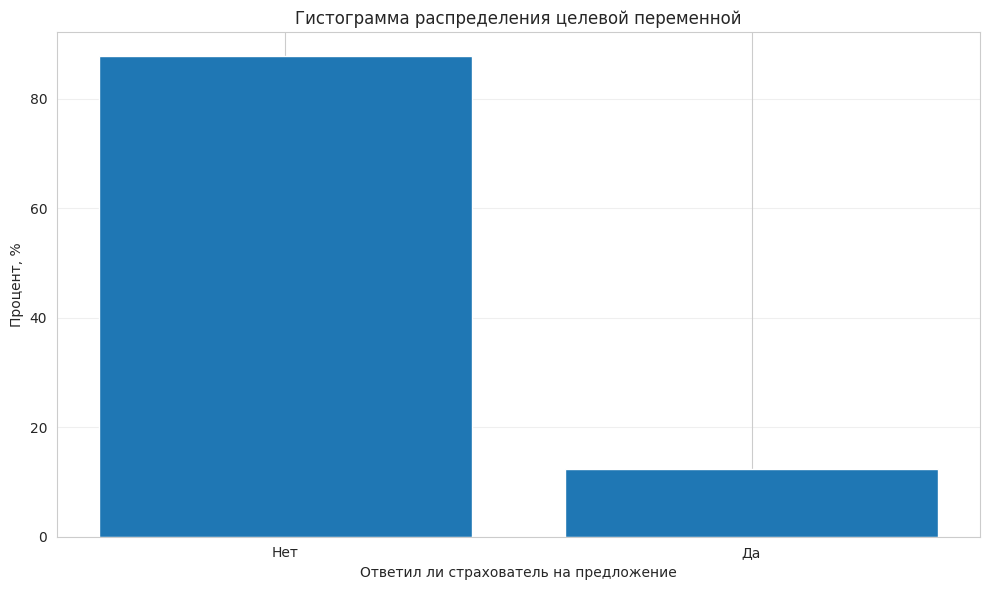

In [10]:
response_counts = df['Response'].value_counts().sort_index()
total_count = len(df)
percentages = (response_counts / total_count) * 100
plt.figure(figsize=(10, 6))
plt.plot(1, 2, 1)
plt.bar(percentages.index.astype(str), percentages.values)
plt.title('Гистограмма распределения целевой переменной')
plt.xlabel('Ответил ли страхователь на предложение')
plt.ylabel('Процент, %')
plt.xticks(percentages.index, ['Нет', 'Да'])
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Вывод:**

Наблюдается сильный дисбаланс целевой переменной в сторону "Нет", что может повлиять на предсказания модели

<a id="eda-distribution"></a>

## 1.3. Распределения

### 1.3.1 Числовые признаки

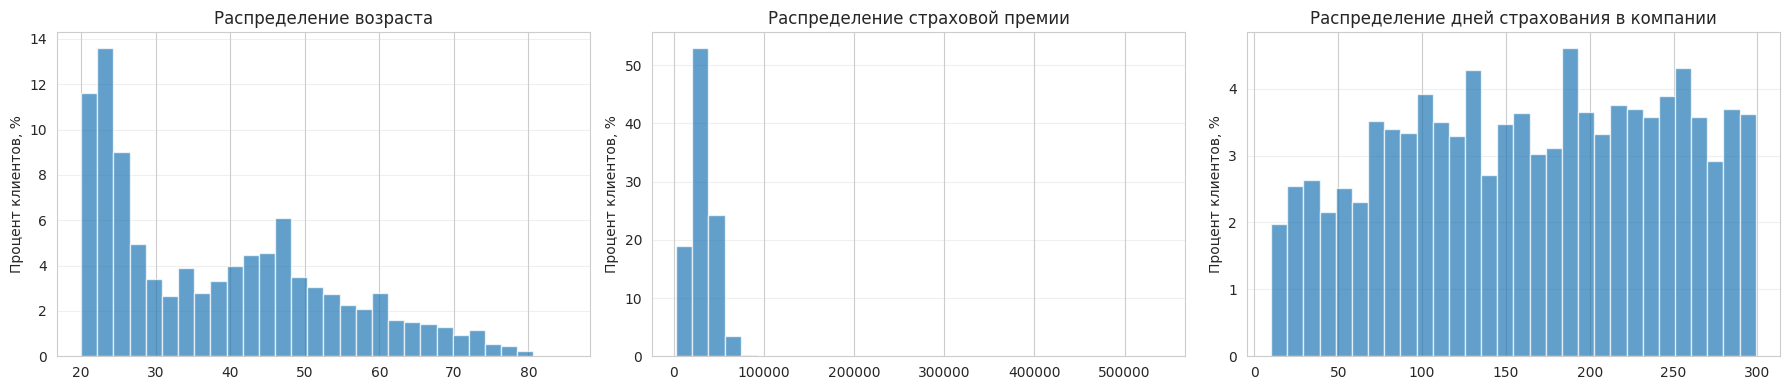

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 4))

def plot_true_percentage_hist(data, ax, title, bins=30):
    counts, bins, patches = ax.hist(data, bins=bins, alpha=0.7, weights=np.ones(len(data)) / len(data) * 100)
    ax.set_title(title)
    ax.set_ylabel('Процент клиентов, %')
    ax.grid(axis='y', alpha=0.3)
    return counts, bins, patches

# Возраст
counts1, bins1, patches1 = plot_true_percentage_hist(df['Age'], ax1, 'Распределение возраста')

# Годовая премия
counts2, bins2, patches2 = plot_true_percentage_hist(df['Annual_Premium'], ax2, 'Распределение страховой премии')

# Vintage
counts3, bins3, patches3 = plot_true_percentage_hist(df['Vintage'], ax3, 'Распределение дней страхования в компании')

plt.tight_layout()
plt.show()

### 1.3.2 Бинарные признаки

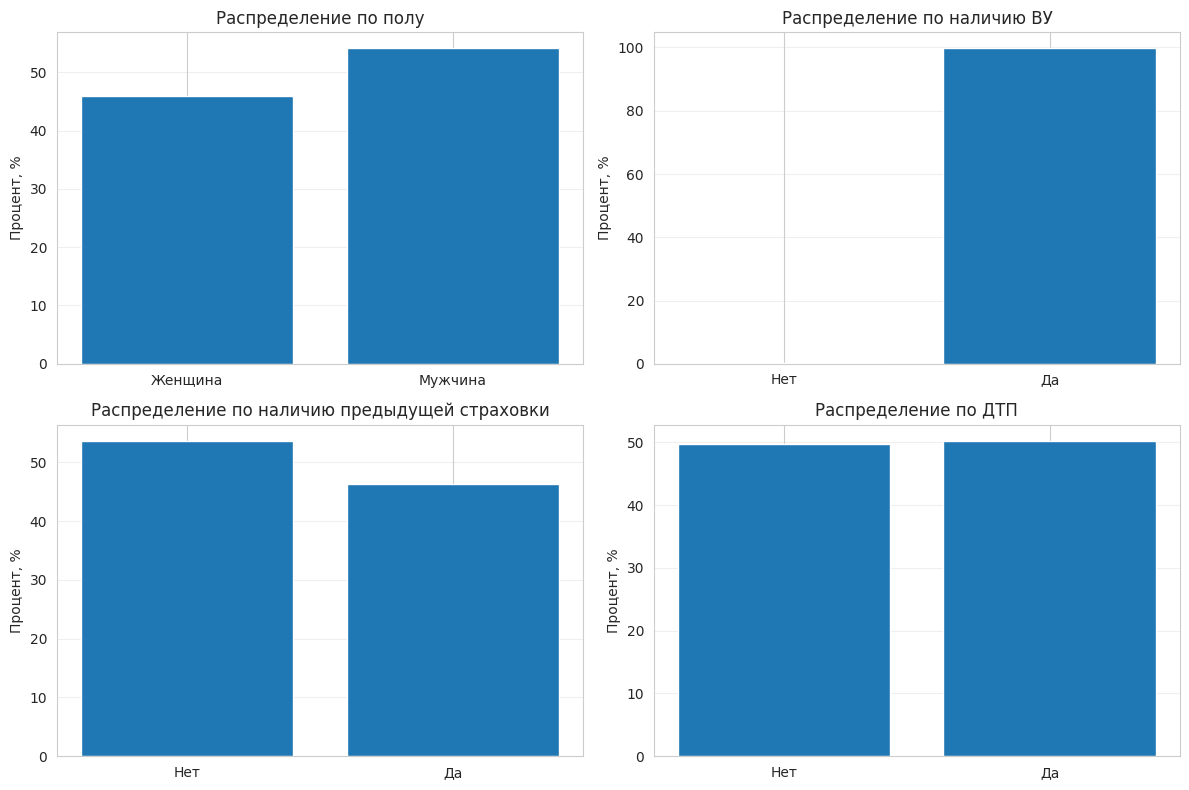

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

response_counts = df['Gender'].value_counts().sort_index()
response_percentages = (response_counts / len(df)) * 100
ax1.bar(['Женщина', 'Мужчина'], response_percentages.values)
ax1.set_title('Распределение по полу')
ax1.set_ylabel('Процент, %')
ax1.grid(axis='y', alpha=0.3)

dl_counts = df['Driving_License'].value_counts().sort_index()
dl_percentages = (dl_counts / len(df)) * 100
ax2.bar(['Нет', 'Да'], dl_percentages.values)
ax2.set_title('Распределение по наличию ВУ')
ax2.set_ylabel('Процент, %')
ax2.grid(axis='y', alpha=0.3)

pi_counts = df['Previously_Insured'].value_counts().sort_index()
pi_percentages = (pi_counts / len(df)) * 100
ax3.bar(['Нет', 'Да'], pi_percentages.values)
ax3.set_title('Распределение по наличию предыдущей страховки')
ax3.set_ylabel('Процент, %')
ax3.grid(axis='y', alpha=0.3)

vd_counts = df['Vehicle_Damage'].value_counts().sort_index()
vd_percentages = (vd_counts / len(df)) * 100
ax4.bar(['Нет', 'Да'], vd_percentages.values)
ax4.set_title('Распределение по ДТП')
ax4.set_ylabel('Процент, %')
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### 1.3.3 Номинальные признаки

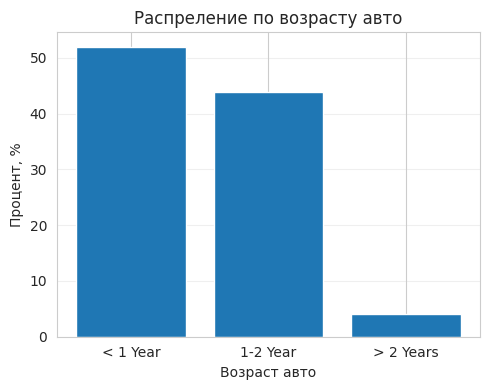

In [13]:
response_counts = df['Vehicle_Age'].value_counts().sort_index()
total_count = len(df)
percentages = (response_counts / total_count) * 100
plt.figure(figsize=(5, 4))
plt.bar(percentages.index.astype(str), percentages.values)
plt.title('Распреление по возрасту авто')
plt.xlabel('Возраст авто')
plt.ylabel('Процент, %')
plt.xticks(percentages.index, ['< 1 Year', '1-2 Year', '> 2 Years'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### 1.3.4 Высококардинальные признаки

In [14]:
region_code_unique = df['Region_Code'].unique()
print(region_code_unique)

[35.  28.  14.   1.  15.  47.  45.   8.  11.   3.  10.  12.  37.  50.
 30.  46.  29.  16.  26.  25.  41.  48.   7.   4.  24.  36.  33.   2.
  9.  27.  18.  43.  49.  17.  13.  38.   6.  21.  23.   0.  19.   5.
 39.  44.  20.  40.  22.  32.  42.  31.  34.  51.  52.  39.2]


### Выводы

- Основной возраст страхования: 20-30, 40-50
- Мужчины чаше берут страховку
- Сильно преобладает количество людей с ВУ (возможно нужно исключить "Driving_License" из обучающей выбоки)
- Больше половины клиентов не имели предыдущей страховки - новые клиенты основная целевая аудитория
- Участие в ДТП в соотношении 50/50 - если были ДТП — выше вероятность покупки
- Чаще страхуют новые авто не старше 2-х лет

<a id="eda-anomaly"></a>

## 1.4. Аномалии


In [15]:
df.describe(include='all')

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,11504798,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07,11504798,11504798,1.150480e+07,1.150480e+07,1.150480e+07,1.150480e+07
unique,2,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,NaN
top,Male,NaN,NaN,NaN,NaN,1-2 Year,Yes,NaN,NaN,NaN,NaN
freq,6228134,NaN,NaN,NaN,NaN,5982678,5783229,NaN,NaN,NaN,NaN
mean,NaN,3.838356e+01,9.980220e-01,2.641869e+01,4.629966e-01,NaN,NaN,3.046137e+04,1.124254e+02,1.638977e+02,1.229973e-01
std,NaN,1.499346e+01,4.443120e-02,1.299159e+01,4.986289e-01,NaN,NaN,1.645475e+04,5.403571e+01,7.997953e+01,3.284341e-01
min,NaN,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,2.630000e+03,1.000000e+00,1.000000e+01,0.000000e+00
25%,NaN,2.400000e+01,1.000000e+00,1.500000e+01,0.000000e+00,NaN,NaN,2.527700e+04,2.900000e+01,9.900000e+01,0.000000e+00
50%,NaN,3.600000e+01,1.000000e+00,2.800000e+01,0.000000e+00,NaN,NaN,3.182400e+04,1.510000e+02,1.660000e+02,0.000000e+00
75%,NaN,4.900000e+01,1.000000e+00,3.500000e+01,1.000000e+00,NaN,NaN,3.945100e+04,1.520000e+02,2.320000e+02,0.000000e+00


Все числовые признаки не должны быть отрицательными - аномалий по этому пункту не обнаружено

In [16]:
df[TARGET_NAME].unique()

array([0, 1])

In [17]:
df['Gender'].unique()

array(['Male', 'Female'], dtype=object)

In [18]:
unique_age = df['Age'].unique()
np.array((sorted(unique_age)))

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
       71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85])

In [19]:
df['Driving_License'].unique()

array([1, 0])

In [20]:
unique_region = df['Region_Code'].unique()
np.array((sorted(unique_region)))

array([ 0. ,  1. ,  2. ,  3. ,  4. ,  5. ,  6. ,  7. ,  8. ,  9. , 10. ,
       11. , 12. , 13. , 14. , 15. , 16. , 17. , 18. , 19. , 20. , 21. ,
       22. , 23. , 24. , 25. , 26. , 27. , 28. , 29. , 30. , 31. , 32. ,
       33. , 34. , 35. , 36. , 37. , 38. , 39. , 39.2, 40. , 41. , 42. ,
       43. , 44. , 45. , 46. , 47. , 48. , 49. , 50. , 51. , 52. ])

Проверяем аномальное значение '39.2' на сколько часто встречается

In [21]:
df[df['Region_Code'] == 39.2].shape[0]

1

In [22]:
df['Previously_Insured'].unique()

array([0, 1])

In [23]:
df['Vehicle_Age'].unique()

array(['1-2 Year', '> 2 Years', '< 1 Year'], dtype=object)

In [24]:
df['Vehicle_Damage'].unique()

array(['Yes', 'No'], dtype=object)

In [25]:
unique_policy_channel = df['Policy_Sales_Channel'].unique()
np.array(sorted(unique_policy_channel))

array([  1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,
        12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,
        23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,
        34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,
        45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,
        56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,
        67.,  68.,  69.,  70.,  71.,  73.,  74.,  75.,  76.,  78.,  79.,
        80.,  81.,  82.,  83.,  86.,  87.,  88.,  89.,  90.,  91.,  92.,
        93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101., 102., 103.,
       104., 105., 106., 107., 108., 109., 110., 111., 112., 113., 114.,
       115., 116., 117., 118., 119., 120., 121., 122., 123., 124., 125.,
       126., 127., 128., 129., 130., 131., 132., 133., 134., 135., 136.,
       137., 138., 139., 140., 145., 146., 147., 148., 150., 151., 152.,
       153., 154., 155., 156., 157., 158., 159., 16

In [26]:
df['Vintage'].unique()

array([187, 288, 254,  76, 294, 197, 190, 262,  36, 125, 215,  30, 203,
       259, 245, 150, 240, 242, 117, 151, 169, 185, 264,  38, 152, 284,
        25, 204, 181, 275,  95, 260, 222, 227, 273, 290,  70, 160,  81,
        20, 168, 267, 286, 130,  92, 171, 113, 158, 208,  42,  94, 189,
        84, 228, 194, 249, 129,  11, 120,  16, 298, 226, 159, 100, 230,
       295, 235, 217,  43, 132, 123, 131, 111, 127, 112, 182, 101,  34,
        80, 135, 292,  22, 163, 110,  29,  19,  77, 241, 232, 192, 280,
       252, 281, 253, 114,  74, 270,  17, 186,  61, 255,  21, 145,  27,
        63, 268, 176, 272,  48, 202, 274, 139, 246, 142,  78,  31, 193,
       137, 248, 108,  56, 238, 165, 256, 237, 247, 205,  15, 218, 282,
        24,  86,  90,  75,  54, 164, 278,  91,  49, 105, 251, 219,  53,
       102, 118, 236, 138,  47, 116, 115, 195,  71,  64, 224,  67,  83,
       201, 180, 279, 244, 206, 200, 257, 172, 283, 166, 261,  26, 155,
       285, 291, 128, 184,  65, 178,  79,  69,  40, 198, 234, 26

Больше аномалий не обнаружено

<a id="eda-correlation"></a>

## 1.5. Корреляции

<Axes: title={'center': 'Feature-correlation (pearson)'}>

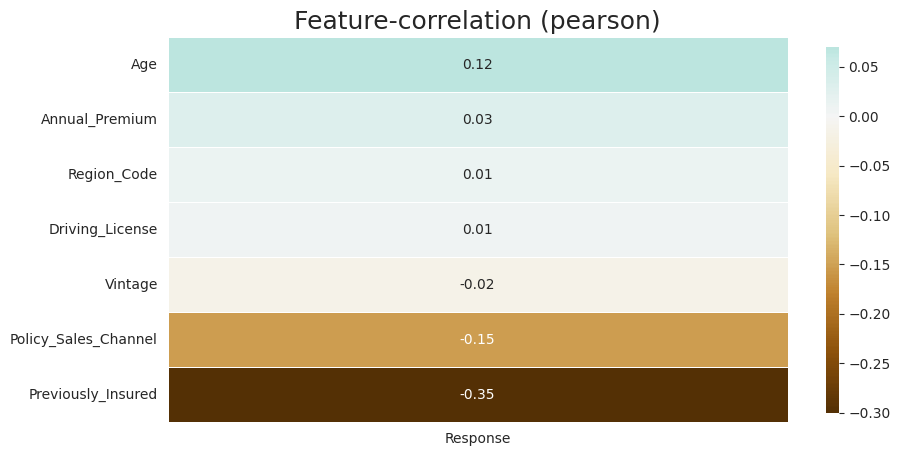

In [27]:
kl.corr_plot(df, figsize=(10,5),target=TARGET_NAME)

interval columns not set, guessing: ['Age', 'Annual_Premium', 'Vintage', 'Response']


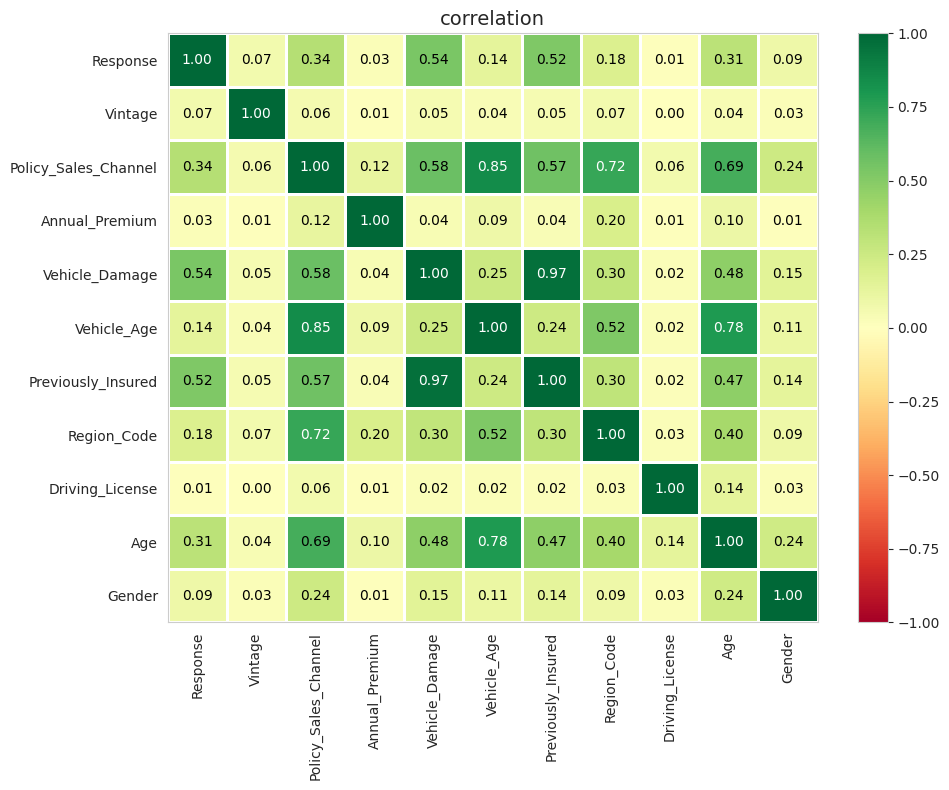

In [105]:
corr_matrix = df.phik_matrix()
plot_correlation_matrix(corr_matrix.values, x_labels=corr_matrix.columns, y_labels=corr_matrix.index, figsize=(10, 8))

**Вывод:**
- Корреляция "Response" и "Vehicle_Damage" +0.54                  - сильный признак (клиенты с ДТП значительно чаще покупают доп страховку)
- Корреляция "Response" и "Previously_Insured" +0.52              - сильный признак (не застрахованные ранее - основная целевая аудитория)
- Корреляция "Response" и "Age" +0.31                             - умеренный признак (старшие клиенты чаще соглашаются на доп страховку)
- Корреляция "Response" и "Region_Code" +0.15          - умеренный признак (клиенты из популярных регионов чаще соглашаются на доп страховку)
- Корреляция "Response" и "Policy_Sales_Channel" +0.27 - умеренный признак (клиенты из популярных каналов продаж чаще соглашаются на доп страховку)
- Корреляция "Response" и "Vehicle_Age" +0.14                     - слабый признак, но полезный (старые авто - выше вероятность согласия на доп страховку)
- Остальные признаки слабо коррелируют с целевой переменной "Response"


<a id="eda-relations"></a>

## 1.6. Анализ взаимосвязей

In [29]:
df_copy = df.copy()

df_copy['Gender'] = df_copy['Gender'].map({'Female': 0, 'Male': 1})
df_copy['Vehicle_Damage'] = df_copy['Vehicle_Damage'].map({'No': 0, 'Yes': 1})
df_copy['Vehicle_Age'] = df_copy['Vehicle_Age'].map({'< 1 Year': 0, '1-2 Year': 1, '> 2 Years': 2}).astype('category')

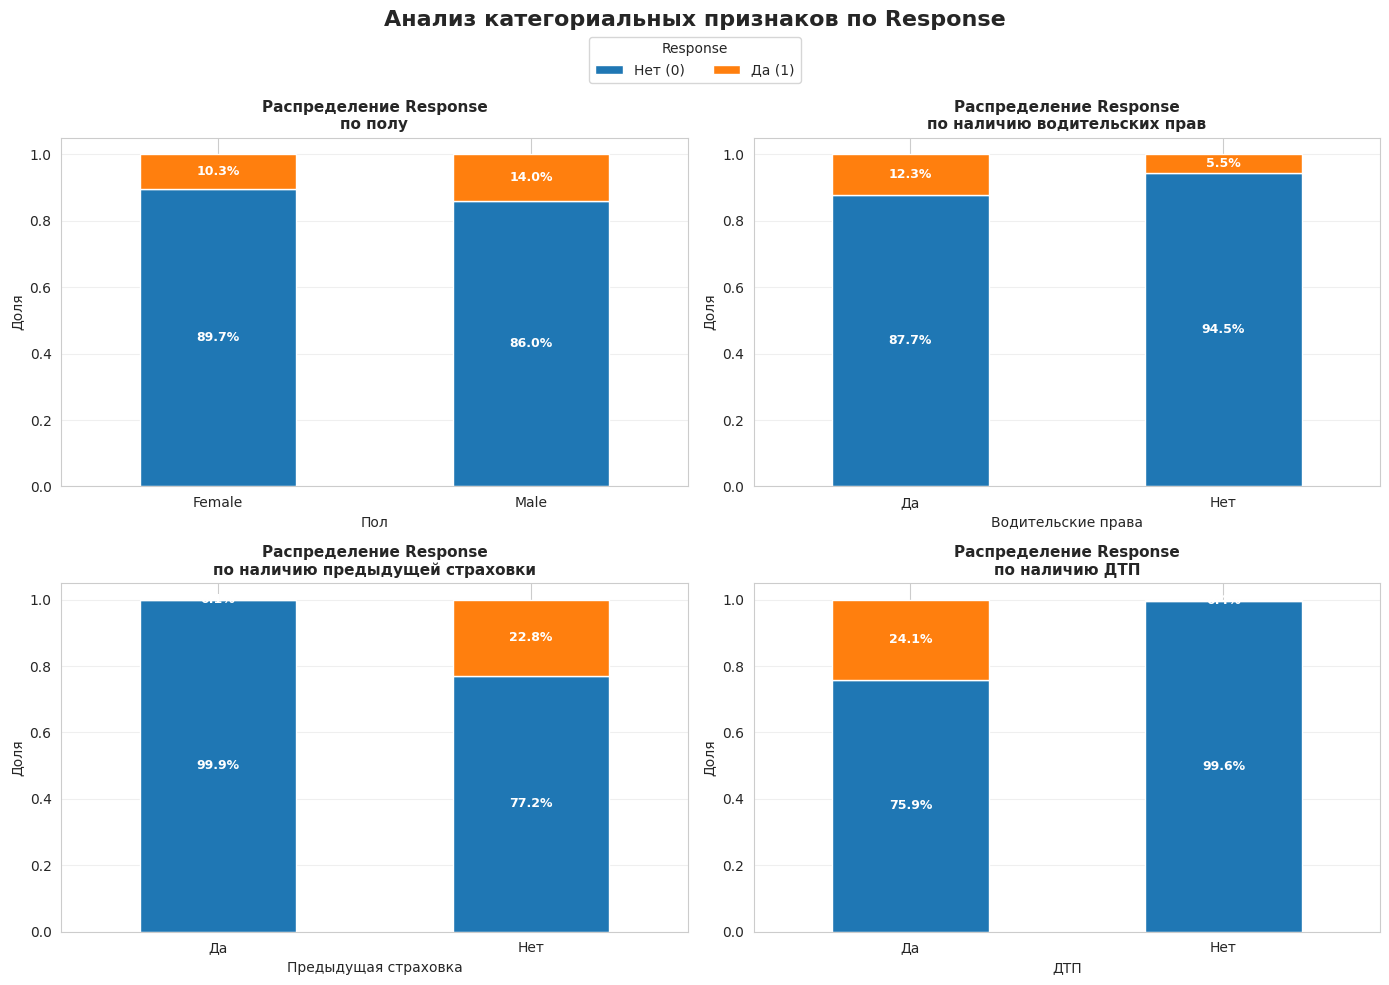

In [30]:
def plot_response_by_category(ax, category, title, xlabel):
    ct = pd.crosstab(category, df_copy['Response'], normalize='index')

    bars = ct.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=['#1f77b4', '#ff7f0e'],
        legend=False
    )

    for container in bars.containers:
        bars.bar_label(
            container,
            labels=[f'{v:.1%}' for v in container.datavalues],
            label_type='center',
            fontsize=9,
            color='white',
            weight='bold'
        )

    ax.set_title(f'Распределение Response\nпо {title}', fontsize=11, weight='bold')
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel('Доля', fontsize=10)
    ax.tick_params(axis='x', rotation=0)
    ax.grid(axis='y', alpha=0.3)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Анализ категориальных признаков по Response', fontsize=16, weight='bold')

axes = axes.flatten()

categories = [
    df_copy['Gender'].map({0: 'Female', 1: 'Male'}),
    df_copy['Driving_License'].map({0: 'Нет', 1: 'Да'}),
    df_copy['Previously_Insured'].map({0: 'Нет', 1: 'Да'}),
    df_copy['Vehicle_Damage'].map({0: 'Нет', 1: 'Да'})
]

titles = [
    'полу',
    'наличию водительских прав',
    'наличию предыдущей страховки',
    'наличию ДТП'
]

xlabels = ['Пол', 'Водительские права', 'Предыдущая страховка', 'ДТП']

for i in range(4):
    plot_response_by_category(axes[i], categories[i], titles[i], xlabels[i])

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, ['Нет (0)', 'Да (1)'], title='Response', loc='upper center', ncol=2, bbox_to_anchor=(0.5, 0.96))

plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()

**Вывод:**

1. Мужчины чаще берут доп страховку, нежели женщины
2. Люди с ВУ чаще берут доп страховку, нежели без ВУ
3. Люди, без предыдущей страховки, чаще берут доп страховку. Те, кто продлевает, практически никогда не берут доп страховку
4. Люди, ранее попадавшие в ДТП, чаще берут страховку. Те, кто не попадал в ДТП,  практически никогда не берут доп страховку

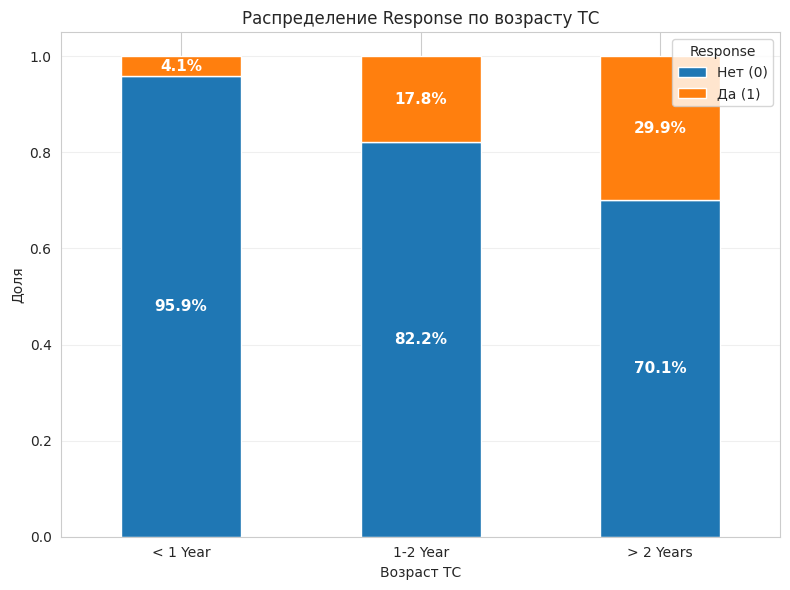

In [31]:
ct = pd.crosstab(df_copy['Vehicle_Age'].map({0: '< 1 Year', 1: '1-2 Year', 2: '> 2 Years'}), df_copy['Response'], normalize='index')

ax = ct.plot(kind='bar', stacked=True, figsize=(8, 6), color=['#1f77b4', '#ff7f0e'])

for container in ax.containers:
    ax.bar_label(container,
                 labels=[f'{v:.1%}' for v in container.datavalues],
                 label_type='center', fontsize=11, color='white', weight='bold')

plt.title('Распределение Response по возрасту ТС')
plt.xlabel('Возраст ТС')
plt.ylabel('Доля')
plt.xticks(rotation=0)
plt.legend(title='Response', labels=['Нет (0)', 'Да (1)'])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Вывод:**
- чем старше авто, тем выше вероятность, что человек возьмет доп страховку

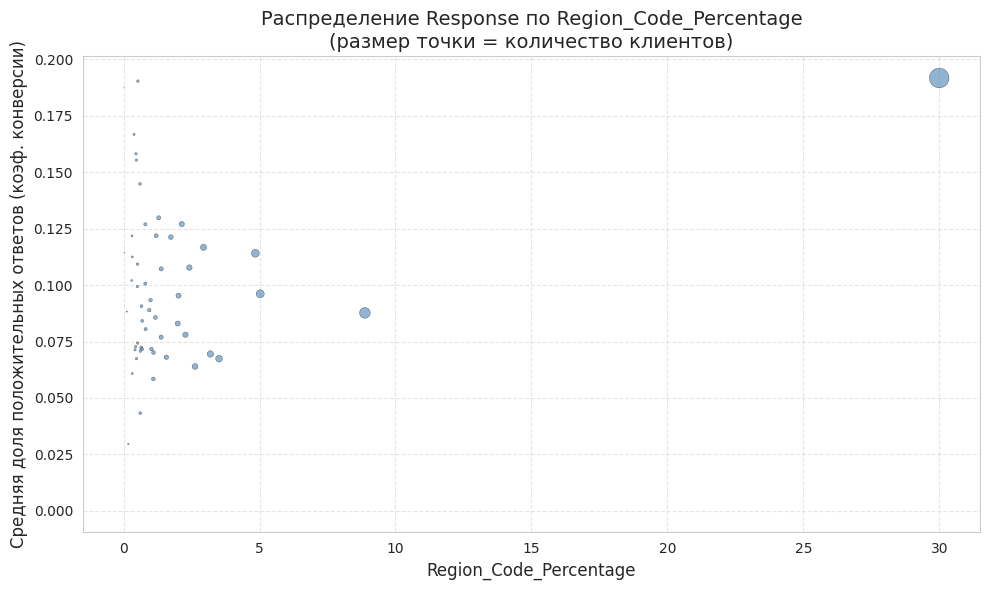

In [32]:
region_percentages = (df_copy['Region_Code'].value_counts() / len(df_copy)) * 100
df_copy['Region_Code_Percentage'] = df_copy['Region_Code'].map(region_percentages)

df_copy['Response'] = pd.to_numeric(df_copy['Response'])
df_copy['Region_Code_Percentage'] = pd.to_numeric(df_copy['Region_Code_Percentage'])

agg_df = df_copy.groupby('Region_Code_Percentage')['Response'].agg(['mean', 'size']).reset_index()
agg_df = agg_df.sort_values('Region_Code_Percentage')

sizes = agg_df['size'] / agg_df['size'].max() * 200

plt.figure(figsize=(10, 6))
plt.scatter(
    agg_df['Region_Code_Percentage'],
    agg_df['mean'],
    s=sizes,
    color='steelblue',
    alpha=0.6,
    edgecolor='k',
    linewidth=0.3
)

plt.xlabel('Region_Code_Percentage', fontsize=12)
plt.ylabel('Средняя доля положительных ответов (коэф. конверсии)', fontsize=12)
plt.title('Распределение Response по Region_Code_Percentage\n(размер точки = количество клиентов)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Вывод:**
- Популярность региона коррелирует с конверсией - чем больше клиентов в регионе, тем выше вероятность, что они купят допуслугу

Всего уникальных продавцов: 152
Продавцов с частотностью >1%: 8


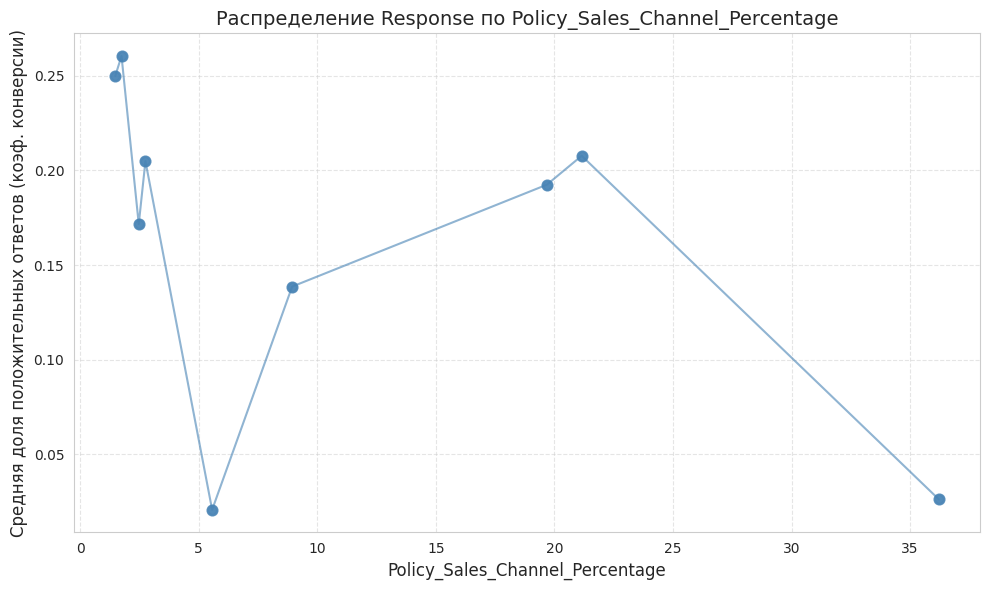

In [33]:
channel_counts = df_copy['Policy_Sales_Channel'].value_counts(normalize=True) * 100
print(f"Всего уникальных продавцов: {len(channel_counts)}")

top_channels = channel_counts[channel_counts > 1].index
print(f"Продавцов с частотностью >1%: {len(top_channels)}")

df_copy['Policy_Sales_Channel_Grouped'] = df_copy['Policy_Sales_Channel'].apply(
    lambda x: x if x in top_channels else 'Other'
)

grouped_freq = df_copy['Policy_Sales_Channel_Grouped'].value_counts(normalize=True)
channel_percentages = grouped_freq * 100

df_copy['Policy_Sales_Channel_Percentage'] = df_copy['Policy_Sales_Channel_Grouped'].map(channel_percentages)

df_copy['Response'] = pd.to_numeric(df_copy['Response'])
df_copy['Policy_Sales_Channel_Percentage'] = pd.to_numeric(df_copy['Policy_Sales_Channel_Percentage'])

agg_df = df_copy.groupby('Policy_Sales_Channel_Percentage')['Response'].mean().reset_index()
agg_df = agg_df.sort_values('Policy_Sales_Channel_Percentage')

plt.figure(figsize=(10, 6))
plt.scatter(agg_df['Policy_Sales_Channel_Percentage'], agg_df['Response'], color='steelblue', s=60, alpha=0.8)
plt.plot(agg_df['Policy_Sales_Channel_Percentage'], agg_df['Response'], color='steelblue', linestyle='-', marker='o', alpha=0.6)

plt.xlabel('Policy_Sales_Channel_Percentage', fontsize=12)
plt.ylabel('Средняя доля положительных ответов (коэф. конверсии)', fontsize=12)
plt.title('Распределение Response по Policy_Sales_Channel_Percentage', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

**Вывод:**
- Конверсия по каналам продаж нелинейно зависит от их популярности - не самые массовые, а нишевые или средние каналы работают лучше всего

## 1.7. Feature Engineering

Найдены потенциально полезные признаки для feature engineering:

- Log_Annual_Premium = логарифмирование Annual_Premium — делает распределение ближе к нормальному, что улучшает стабильность и точность модели.
- Age_to_Vintage = Age / (Vintage + 1) — отражает, насколько «зрелый» клиент относительно продолжительности его взаимодействия со страховой компанией.
- Premium_to_Age = Annual_Premium / (Age + 1) — позволяет оценить, насколько «дорого» застрахован клиент в контексте его возраста.
- Premium_to_Vintage = Annual_Premium / (Vintage + 1) — показывает соотношение премии к длительности взаимоотношений с компанией.
- Age_Group = категоризация Age на группы: 0–25, 25–35, 35–45, 45–55, 55–100 — упрощает учёт нелинейной зависимости возраста от целевой переменной.
- Premium_Group = квинтильная категоризация Annual_Premium на 5 групп — преобразует непрерывную переменную в порядковую, помогая модели улавливать нелинейные пороговые эффекты премии.
- No_Insurance_But_Damage = 1, если Previously_Insured = 0 и Vehicle_Damage = 'Yes' — выделяет группу риска: клиенты без предыдущей страховки, но уже имеющие повреждения автомобиля.
- Age_Premium_Interaction = Age * Annual_Premium / 1000 — отражает мультипликативное взаимодействие возраста и премии, моделируя совокупный «вес» клиента.
- Licensed_Adult = 1, если Driving_License = 1 и Age ≥ 18 — выделяет типичных взрослых водителей, фильтруя нетипичные случаи и повышая устойчивость модели на реальных данных.
- Region_Channel = конкатенация Region_Code и Policy_Sales_Channel — формирует уникальный идентификатор комбинации региона и канала продаж.
- Vintage_Group = категоризация Vintage на группы — помогает выявить нелинейные эффекты, связанные с «свежестью» клиента.

Все перечисленные признаки были протестированы на оптимизированных моделях LightGBM и CatBoost. Однако ни один из них не привёл к улучшению метрики F1 — наоборот, качество моделей ухудшилось. Следовательно, включение этих признаков в финальную модель является избыточным и нецелесообразным.

<a id="eda-preprocessing"></a>

## 1.8. Стратегия предобработки

Выводы:

  Для всего датасета:

    1. В Region Code аномальное значение '39.2' встречается только 1 раз, можно просто удалить эту строку из датасета
    2. Для моделей со встроенной предобработкой категориальных признаков переведем категориальные сразу в тип category

  В пайплайне препроцессора:

    1. Так как пропуски отсутствуют, предобработку пропусков не делаем
    2. Дубликаты также отстуствуют
    3. Выявлены бинарные признаки: Gender, Driving_License, Previously_Insured, Vehicle_Damage. Для них применим One-Hot Encoding с drop='first'
    4. Выявлены порядковые признаки: Age, Vehicle_Age, Vintage. Age и Vintage уже числовые значения - преобразовывать не надо, а для Vehicle_Age будем использовать OrdinalEncoder
    5. Так как в Annual_Premium сильные выбросы, то для данного признака будем применять RobustScaler вместо StandardScaler
    6. Для высококардинальных признаков Region_Code, Policy_Sales_Channel будет использован кастомный трансформер для частотного кодирования




---



In [34]:
df = df[df['Region_Code'] != 39.2]

In [35]:
columns_to_convert = ["Region_Code", "Policy_Sales_Channel", "Vehicle_Damage", "Gender", "Previously_Insured", "Driving_License"]

df[columns_to_convert] = df[columns_to_convert].apply(
    lambda x: x.astype(str).astype('category')
)

df['Gender'] = df['Gender'].map({'Female': 0, 'Male': 1})
df['Vehicle_Damage'] = df['Vehicle_Damage'].map({'No': 0, 'Yes': 1})

<a id="methodology"></a>
# 2. Методология и Валидация

<a id="methodology-metrics"></a>
## 2.1. Метрики качества

**Метрика качества F1:**
В задаче с дисбалансом (85% - «0» и 15% - «1») метрика F1 важна, потому что она сочетает точность (Precision) и полноту (Recall) — то есть учитывает и то, насколько мы уверены в «1», и то, сколько «1» мы вообще нашли

<a id="methodology-val"></a>
## 2.2. Схема валидации

- Будет использована стратифицированная кросс-валидация, так как в датасете дисбланс целевой переменной.
- Разделение train/test до преобразований (скейлинг, кодирование)
- Fit только на train - все трансформеры обучаются на train
- Pipeline - все шаги в пайплайне
- Кросс-валидация с Pipeline - предотвращает утечки между фолдами
- Статистическая проверка - сравнение статистик

<a id="model"></a>
# 3. Моделирование и Оптимизация

<a id="model-split-data"></a>
### 3.1.1. Сэмплирование и разделения на train и test

Перед моделированием:
-  возьмем подвыборку c frac=0.03 из датасета (345 144 строк) для ускоренного обучения при этом при сэмплировании стратифицируем по targetу
- разделим датасет на train и test, применяя стратификацию по таргету

In [36]:
df_sample = df.groupby(TARGET_NAME).apply(lambda x: x.sample(frac=0.03, random_state=RANDOM_STATE))

X = df_sample.drop(TARGET_NAME, axis=1)
y = df_sample[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    stratify=y,
    random_state=RANDOM_STATE
)

print(f"Размер train на подвыборке: {X_train.shape}")
print(f"Размер test на подвыборке: {X_test.shape}")
print()
print("Баланс классов в train:\n", y_train.value_counts(normalize=True), sep="")
print("Баланс классов в test:\n", y_test.value_counts(normalize=True), sep="")

Размер train на подвыборке: (258858, 10)
Размер test на подвыборке: (86286, 10)

Баланс классов в train:
Response
0    0.877002
1    0.122998
Name: proportion, dtype: float64
Баланс классов в test:
Response
0    0.877002
1    0.122998
Name: proportion, dtype: float64


In [37]:
df_sample.shape

(345144, 11)

Перепроверим, что дисбаланс такой же как и по всей выборке

In [38]:
X_all = df.drop(TARGET_NAME, axis=1)
y_all = df[TARGET_NAME]

X_all_train, X_all_test, y_all_train, y_all_test = train_test_split(
    X_all, y_all,
    stratify=y_all,
    random_state=RANDOM_STATE
)

print(f"Размер train на всех данных\n: {X_all_train.shape}")
print(f"Размер test на всех данных\n: {X_all_test.shape}")
print()
print("Баланс классов в train на всех данных:\n", y_all_train.value_counts(normalize=True), sep="")
print("Баланс классов в test на всех данных:\n", y_all_test.value_counts(normalize=True), sep="")

Размер train на всех данных
: (8628597, 10)
Размер test на всех данных
: (2876200, 10)

Баланс классов в train на всех данных:
Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64
Баланс классов в test на всех данных:
Response
0    0.877003
1    0.122997
Name: proportion, dtype: float64


Удаляем X_all, y_all, X_all_train, X_all_test, y_all_train, y_all_test для освобождения памяти и потому что они нужны были только для перепроверки

In [39]:
del X_all
del y_all
del X_all_train
del X_all_test
del y_all_train
del y_all_test

gc.collect()

6694

<a id="model-utils"></a>
## 3.2.1 Функции-утилиты и препроцессор

### 3.2.1. Декоратор для замера времени функций

In [40]:
def time_function(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"\n[{time.strftime('%H:%M:%S')}] Запуск: {func.__name__}...")
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed = end_time - start_time
        print(f"[{time.strftime('%H:%M:%S')}] Завершено {func.__name__} через {timedelta(seconds=int(elapsed))}")
        return result
    return wrapper

### 3.2.2. Функция оценки модели по тестовой выборке

In [41]:
@time_function
def evaluate_model(y_true, y_pred, y_pred_proba, name=''):
    print(f'Оценка модели {name}:')

    metrics = {
        'precision': precision_score(y_true, y_pred),
        'recall': recall_score(y_true, y_pred),
        'f1': f1_score(y_true, y_pred),
        'roc_auc': roc_auc_score(y_true, y_pred_proba)
    }

    return metrics

### 3.2.3. Кастомный трансформер для частотного кодирования

**Почему кастомный класс, а не готовое решение**:
- Больше контроля над процессом
- Легче интегрировать в sklearn пайплайн
- Прозрачность преобразований

In [42]:
class ThresholdFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01, other_name='OTHER'):
        self.threshold = threshold
        self.other_name = other_name
        self.freq_maps_ = {}
        self.columns_ = []

    def fit(self, X, y=None):
        self.columns_ = X.columns.tolist()

        for col in self.columns_:
            value_counts = X[col].value_counts(normalize=True)
            common_categories = value_counts[value_counts >= self.threshold].index
            freq_map = {}
            for cat in common_categories:
                freq_map[cat] = value_counts[cat]
            other_categories = value_counts[value_counts < self.threshold].index
            other_freq = value_counts[other_categories].sum() if len(other_categories) > 0 else 0
            freq_map[self.other_name] = other_freq
            self.freq_maps_[col] = freq_map

        return self

    def transform(self, X):
        X_copy = X.copy()

        for col in self.columns_:
            if col not in X_copy.columns:
                continue
            temp_col = X_copy[col].astype(str)
            common_categories = list(self.freq_maps_[col].keys())
            common_categories.remove(self.other_name)
            temp_col = temp_col.where(
                temp_col.isin(common_categories),
                other=self.other_name
            )
            encoded_values = temp_col.map(self.freq_maps_[col])
            encoded_values = encoded_values.fillna(self.freq_maps_[col][self.other_name])
            X_copy[col] = encoded_values

        return X_copy

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return self.columns_
        return input_features

### 3.2.4. Функция создания препроцессора

In [43]:
def create_preprocessor(skip_encoders=False):
  high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
  bool_cols = ["Vehicle_Damage", "Gender", "Previously_Insured", "Driving_License"]
  ord_cols = ['Vehicle_Age']
  outliers_num_cols = ["Annual_Premium"]
  num_cols = ["Age", "Vintage"]

  preprocessor = None

  if (skip_encoders):
      preprocessor = ColumnTransformer(
        transformers=[
            ("outliers_num", RobustScaler(), outliers_num_cols),
            ("num", StandardScaler(), num_cols),
            ("ord", OrdinalEncoder(
                categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
                dtype=np.int32
            ), ord_cols),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )
  else:
      preprocessor = ColumnTransformer(
        transformers=[
            ("outliers_num", RobustScaler(), outliers_num_cols),
            ("num", StandardScaler(), num_cols),
            ("high_cat", ThresholdFrequencyEncoder(threshold=0.01, other_name='OTHER'), high_card_cols),
            ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
            ("ord", OrdinalEncoder(
                categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
                dtype=np.int32
            ), ord_cols),
        ],
        remainder='passthrough',
        verbose_feature_names_out=False
    )

  return preprocessor

### 3.2.5. Общий класс для моделей

In [44]:
class ModelFactory:
  def __init__(self, name="", param_grid=None, scoring='f1', threshold=0.69, random_state=RANDOM_STATE, n_jobs=N_JOBS, **kwargs):
      self.name = name
      self.random_state = random_state
      self.n_jobs = n_jobs
      self.pipeline = None
      self.y_train_pred = None
      self.y_train_pred_proba = None
      self.y_test_pred = None
      self.y_test_pred_proba = None
      self.X_train = None
      self.y_train = None

      self.param_grid = param_grid
      self.scoring = scoring
      self.best_params_ = None
      self.grid_search = None

      self.threshold = 0.5

      # Optuna атрибуты
      self.study = None
      self.best_trial_params = None
      self.best_trial_value = None
      self.evaluated_results = None

      # Атрибуты для хранения времени выполнения
      self.timing_info = {
          'fit_time': None,
          'predict_time': None,
          'grid_search_time': None,
          'optuna_time': None
      }

      self._create_pipeline()
      print(self.name)

  def _create_pipeline(self):
      pass

  def get_evaluated_results(self):
      return self.evaluated_results

  def get_timing_info(self):
      timing_df = pd.DataFrame({
          'Операция': list(self.timing_info.keys()),
          'Время (сек)': list(self.timing_info.values())
      })
      print(timing_df.to_string(index=False))
      return self.timing_info

  def _get_optuna_params(self, trial):
      raise NotImplementedError("Метод должен быть реализован в дочернем классе")

  def run_base(self, X_train, y_train, X_test, y_test):
      self.fit(X_train, y_train)
      self.predict(X_test)
      self.evaluate(y_test)

  @time_function
  def fit(self, X_train, y_train):
      self.X_train = X_train
      self.y_train = y_train

      start_time = time.time()
      self.pipeline.fit(X_train, y_train)
      fit_time = time.time() - start_time
      self.timing_info['fit_time'] = fit_time
      print(f"Время обучения: {fit_time:.2f} секунд")

      self.y_train_pred = self.pipeline.predict(X_train)
      self.y_train_pred_proba = self.pipeline.predict_proba(X_train)

      return self

  @time_function
  def predict(self, X_test):
      start_time = time.time()
      self.y_test_pred_proba = self.pipeline.predict_proba(X_test)
      predict_time = time.time() - start_time
      self.timing_info['predict_time'] = predict_time
      print(f"Время предсказания: {predict_time:.2f} секунд")

      probabilities = self.pipeline.predict_proba(X_test)[:, 1]
      self.y_test_pred = (probabilities >= self.threshold).astype(int)

      return self.y_test_pred, self.y_test_pred_proba

  @time_function
  def fit_with_grid_search(self, X_train, y_train):
      start_time = time.time()

      self.grid_search = GridSearchCV(
          self.pipeline,
          self.param_grid,
          cv=StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE),
          scoring=self.scoring,
          n_jobs=self.n_jobs,
          verbose=1
      )

      print("Запуск GridSearchCV...")
      self.grid_search.fit(X_train, y_train)

      grid_search_time = time.time() - start_time
      self.timing_info['grid_search_time'] = grid_search_time
      print(f"\nВремя выполнения GridSearchCV: {grid_search_time:.2f} секунд")

      # Сохраняем лучшие параметры
      self.best_params_ = self.grid_search.best_params_
      self.pipeline = self.grid_search.best_estimator_

      print(f"\nЛучшие параметры: {self.best_params_}")
      print(f"Лучший score ({self.scoring}): {self.grid_search.best_score_:.4f}")

      # Обновляем предсказания на тренировочных данных
      self.X_train = X_train
      self.y_train = y_train
      self.y_train_pred = self.pipeline.predict(X_train)
      self.y_train_pred_proba = self.pipeline.predict_proba(X_train)

      return self

  def get_grid_search_results(self):
      if self.grid_search is None:
          print("Сначала выполните fit_with_grid_search()")
          return None

      results_df = pd.DataFrame(self.grid_search.cv_results_)

      # Добавляем информацию о времени
      if 'mean_fit_time' in results_df.columns and 'mean_score_time' in results_df.columns:
          print(f"\nСреднее время обучения на фолд: {results_df['mean_fit_time'].mean():.2f} сек")
          print(f"Среднее время предсказания на фолд: {results_df['mean_score_time'].mean():.2f} сек")

      # Выводим важные колонки
      important_cols = ['params', 'mean_test_score', 'std_test_score', 'rank_test_score']
      if all(col in results_df.columns for col in important_cols):
          display_df = results_df[important_cols].sort_values('rank_test_score')
          print("\nРезультаты GridSearchCV:")
          print(display_df.to_string())

      return results_df

  @time_function
  def run_grid(self, X_train, y_train, X_test, y_test):
      self.fit_with_grid_search(X_train, y_train)
      self.predict(X_test)
      self.evaluate(y_test)

  def _add_classifier_prefix(self, params):
      prefixed_params = {}
      for key, value in params.items():
          if key.startswith('classifier__'):
              prefixed_params[key] = value
          else:
              # Добавляем префикс для параметров классификатора
              prefixed_params[f'classifier__{key}'] = value
      return prefixed_params

  def _create_optuna_objective(self, X_train, y_train):
      scorer = get_scorer(self.scoring)

      def objective(trial):
          params = self._get_optuna_params(trial)

          pipeline_clone = clone(self.pipeline)
          pipeline_clone.set_params(**params)

          cv = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=self.random_state)
          scores = []
          fold_times = []

          for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train)):
              X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
              y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

              # Обучение на фолде с замером времени
              fold_start_time = time.time()
              pipeline_clone.fit(X_tr, y_tr)
              fold_fit_time = time.time() - fold_start_time
              fold_times.append(fold_fit_time)

              # Предсказание на валидации
              if hasattr(scorer, '_score_func') and scorer._score_func.__name__ == 'roc_auc_score':
                  y_val_proba = pipeline_clone.predict_proba(X_val)[:, 1]
                  score = scorer._score_func(y_val, y_val_proba)
              else:
                  y_val_pred = pipeline_clone.predict(X_val)
                  score = scorer._score_func(y_val, y_val_pred)

              scores.append(score)

              # Отчет для pruning
              trial.report(score, fold_idx)
              if trial.should_prune():
                  raise optuna.TrialPruned()

          # Сохраняем среднее время обучения на фолд в trial
          trial.set_user_attr('mean_fit_time_per_fold', np.mean(fold_times))

          # Возвращаем средний score
          return np.mean(scores)

      return objective

  @time_function
  def fit_with_optuna(self, X_train, y_train, n_trials=30):
      start_time = time.time()

      study_name = f"{self.name}_optuna"
      storage = optuna.storages.InMemoryStorage()

      # Настраиваем Optuna
      sampler = TPESampler(
          seed=self.random_state,
          n_startup_trials=min(10, n_trials // 3),
          n_ei_candidates=10,
      )

      study = optuna.create_study(
          direction="maximize",
          study_name=study_name,
          sampler=sampler,
          pruner=MedianPruner(
              n_startup_trials=2,
              n_warmup_steps=0,
              interval_steps=1,
              n_min_trials=1,
          ),
          storage=storage,
          load_if_exists=False,
      )

      print(f"Запуск Optuna optimization для {self.name}...")
      print(f"Количество попыток: {n_trials}")
      print(f"Метрика оптимизации: {self.scoring}")

      # Создаем objective функцию
      objective = self._create_optuna_objective(X_train, y_train)

      # Запускаем оптимизацию
      study.optimize(objective, n_trials=n_trials, n_jobs=1)  # n_jobs=1 для стабильности

      optuna_time = time.time() - start_time
      self.timing_info['optuna_time'] = optuna_time
      print(f"\nВремя выполнения Optuna: {optuna_time:.2f} секунд")

      # Сохраняем результаты
      self.study = study
      self.best_trial_params = study.best_params
      self.best_trial_value = study.best_value

      # Выводим информацию о времени из лучшего trial
      if study.best_trial:
          mean_fit_time = study.best_trial.user_attrs.get('mean_fit_time_per_fold', None)
          if mean_fit_time:
              print(f"Среднее время обучения на фолд (лучшая конфигурация): {mean_fit_time:.2f} секунд")

      print("\nРЕЗУЛЬТАТЫ OPTUNA:")
      print(f"Лучшие параметры ({self.scoring}):")
      for key, value in study.best_params.items():
          print(f"  {key}: {value}")
      print(f"Лучшее значение: {study.best_value:.4f}")

      # Обновляем pipeline с лучшими параметрами
      best_params_with_prefix = self._add_classifier_prefix(study.best_params)
      print(best_params_with_prefix)
      self.pipeline.set_params(**best_params_with_prefix)

      # Обучаем на всех данных с лучшими параметрами
      self.pipeline.fit(X_train, y_train)

      # Обновляем предсказания на тренировочных данных
      self.X_train = X_train
      self.y_train = y_train
      self.y_train_pred = self.pipeline.predict(X_train)
      self.y_train_pred_proba = self.pipeline.predict_proba(X_train)

      return self

  @time_function
  def run_optuna(self, X_train, y_train, X_test, y_test, n_trials=30):
      self.fit_with_optuna(
          X_train, y_train,
          n_trials=n_trials,
      )

      self.predict(X_test)

      self.evaluate(y_test)

      return self

  @time_function
  def evaluate(self, y_test=None, evaluate_train=True, evaluate_test=True):
      results = {}

      if evaluate_train:
          train_metrics, cm = self._evaluate_set(
              self.y_train,
              self.y_train_pred,
              self.y_train_pred_proba,
              'Train'
          )
          results['train'] = train_metrics

      if evaluate_test and y_test is not None:
          test_metrics, test_cm = self._evaluate_set(
              y_test,
              self.y_test_pred,
              self.y_test_pred_proba,
              'Test'
          )
          results['test'] = test_metrics

      self.evaluated_results = results

      # Добавляем информацию о времени в результаты
      if self.timing_info['fit_time']:
          results['timing'] = {
              'fit_time': self.timing_info['fit_time'],
              'predict_time': self.timing_info['predict_time'],
              'grid_search_time': self.timing_info['grid_search_time'],
              'optuna_time': self.timing_info['optuna_time']
          }

      if evaluate_train and evaluate_test and y_test is not None:
          self._compare_train_test()

      return results

  def _evaluate_set(self, y_true, y_pred, y_pred_proba, plot_title=''):
      metrics = evaluate_model(
          y_true,
          y_pred,
          y_pred_proba[:, 1],
          self.name
      )

      cm = confusion_matrix(y_true, y_pred)

      fig, axes = plt.subplots(1, 2, figsize=(10, 4))

      print("\nОценка на " + plot_title)
      print(classification_report(y_true, y_pred))
      print(metrics)

      sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0], square=True)
      axes[0].set_title(plot_title)

      axes[1].axis('off')

      cell_text = [[k, v] for k, v in metrics.items()]

      table = axes[1].table(
          cellText=cell_text,
          colLabels=['Метрика', 'Значение'],
          colWidths=[0.2, 0.8],
          loc="center"
      )
      table.auto_set_font_size(False)
      table.set_fontsize(10)
      table.scale(1.2, 1.5)

      plt.tight_layout(
          pad=3.0,
          w_pad=4.0,
          h_pad=4.0
      )
      plt.show()

      return metrics, cm

  def _compare_train_test(self):
      print("Сравнение train и test")

      comparison_df = pd.DataFrame({
          'Metric': [],
          'Train': [],
          'Test': [],
          'Difference': []
      })

      metrics_to_compare = ['precision', 'recall', 'f1', 'roc_auc']

      for metric in metrics_to_compare:
          train_val = self.evaluated_results['train'][metric]
          test_val = self.evaluated_results['test'][metric]
          diff = train_val - test_val

          comparison_df = pd.concat([comparison_df, pd.DataFrame({
              'Metric': [metric],
              'Train': [f"{train_val:.4f}"],
              'Test': [f"{test_val:.4f}"],
              'Difference': [f"{diff:+.4f}"]
          })], ignore_index=True)

      train_roc_auc = self.evaluated_results['train']['roc_auc']
      test_roc_auc = self.evaluated_results['test']['roc_auc']
      gap = train_roc_auc - test_roc_auc
      abs_gap = abs(gap)

      # Пороговые значения
      OVERFIT_THRESHOLD = 0.1      # 10% разрыв - переобучение
      UNDERFIT_THRESHOLD = 0.6     # Низкое качество на трейне - недообучение
      MODERATE_THRESHOLD = 0.05    # 5% разрыв - умеренный

      print(f"\nROC-AUC на тренировочных данных: {train_roc_auc:.4f}")
      print(f"ROC-AUC на тестовых данных: {test_roc_auc:.4f}")
      print(f"Разрыв: {gap:+.4f}")

      # Диагностика
      if train_roc_auc < UNDERFIT_THRESHOLD:
          print(f"\nWARNING! СИЛЬНОЕ НЕДООБУЧЕНИЕ!")
          print(f"• Низкое качество на тренировочных данных ({train_roc_auc:.4f} < {UNDERFIT_THRESHOLD})")
          print(f"• Модель слишком простая или недостаточно обучена")
          print(f"• Рекомендации: увеличьте сложность модели, добавьте признаки, увеличьте количество итераций")

      elif train_roc_auc > 0.85 and abs_gap > OVERFIT_THRESHOLD:
          print(f"\nWARNING!  СИЛЬНОЕ ПЕРЕОБУЧЕНИЕ!")
          print(f"• Высокое качество на тренировочных данных ({train_roc_auc:.4f})")
          print(f"• Большой разрыв с тестовыми данными ({abs_gap:.4f} > {OVERFIT_THRESHOLD})")
          print(f"• Рекомендации: увеличьте регуляризацию, уменьшите сложность модели, используйте больше данных")

      elif abs_gap > MODERATE_THRESHOLD:
          if gap > 0:
              print(f"\nWARNING!  УМЕРЕННОЕ ПЕРЕОБУЧЕНИЕ")
              print(f"• Заметный разрыв между данными ({abs_gap:.4f} > {MODERATE_THRESHOLD})")
              print(f"• Рекомендации: рассмотрите увеличение регуляризации (уменьшите C)")
          else:
              print(f"\nWARNING!  НЕОБЫЧНАЯ СИТУАЦИЯ")
              print(f"• Качество на тесте лучше чем на трейне ({gap:+.4f})")
              print(f"• Возможные причины: проблемы с разбиением данных, шум в тренировочных данных")

      elif abs_gap > 0.02:
          print(f"\nWARNING!  НЕБОЛЬШОЙ РАЗРЫВ")
          print(f"• Разрыв присутствует, но не критичный ({abs_gap:.4f})")
          print(f"• Рекомендации: мониторинг производительности")

      else:
          print(f"\nХОРОШАЯ ОБОБЩАЮЩАЯ СПОСОБНОСТЬ")
          print(f"• Небольшой разрыв между данными ({abs_gap:.4f})")
          print(f"• Модель хорошо обобщает")

      print(comparison_df)

      # Добавляем информацию о времени в сравнение
      if 'timing' in self.evaluated_results:
          print(f"\nВремя выполнения:")
          print(f"• Обучение: {self.evaluated_results['timing']['fit_time']:.2f} сек")
          print(f"• Предсказание: {self.evaluated_results['timing']['predict_time']:.2f} сек")
          if self.evaluated_results['timing']['grid_search_time']:
              print(f"• GridSearchCV: {self.evaluated_results['timing']['grid_search_time']:.2f} сек")
          if self.evaluated_results['timing']['optuna_time']:
              print(f"• Optuna: {self.evaluated_results['timing']['optuna_time']:.2f} сек")



### 3.2.6. Функция сравнения по основным метрикам

In [93]:
def plot_metrics_table(results_df):
    fig, ax = plt.subplots(figsize=(10, 3))
    ax.axis('tight')
    ax.axis('off')

    df_display = results_df.copy()
    df_display['Precision'] = df_display['Precision'].round(4)
    df_display['Recall'] = df_display['Recall'].round(4)
    df_display['F1'] = df_display['F1'].round(4)
    df_display['AUC'] = df_display['AUC'].round(4)

    if 'Fit_Time' in df_display.columns:
        df_display['Fit_Time'] = df_display['Fit_Time'].round(1)

    table = ax.table(
        cellText=df_display.values,
        colLabels=df_display.columns,
        cellLoc='center',
        loc='center',
        colColours=["#00CA07"] * len(df_display.columns)  # зелёная шапка
    )
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    plt.title("Сравнение моделей - основные метрики", fontsize=14, pad=20)
    plt.show()

In [92]:
def compare_model_metrics(models_list, is_grid=False, is_optuna=False):
    model_names = ["CatBoost", "Random Forest", "LightGBM", "LogisticRegression"]

    base_models_data = []

    for name, model in zip(model_names, models_list):
        timing = model.get_timing_info()
        eval_results = model.get_evaluated_results()
        test_metrics = eval_results.get("test", {})

        model_dict = {
            "Model": name,
            "Pred_Time": timing.get("predict_time", 0),
            "Precision": test_metrics.get("precision"),
            "Recall": test_metrics.get("recall"),
            "F1": test_metrics.get("f1"),
            "AUC": test_metrics.get("roc_auc"),
        }

        if not is_grid and not is_optuna:
            model_dict["Fit_Time"] = timing.get("fit_time", 0)

        if is_grid:
            model_dict["Fit_Time"] = timing.get("grid_search_time", 0)

        if is_optuna:
            model_dict["Fit_Time"] = timing.get("optuna_time", 0)

        base_models_data.append(model_dict)

    base_models_df = pd.DataFrame(base_models_data).round(
        {"Fit_Time": 2, "Pred_Time": 3, "Precision": 4, "Recall": 4, "F1": 4, "AUC": 4}
    )
    plot_metrics_table(base_models_df)

<a id="model-baseline"></a>
## 3.3. Baseline модель

В качестве baseline модели взята Логистическая регрессия с минимальным набором параметров + class_weight='balanced' для борьбы с дисбалансом

In [45]:
class LogisticRegressionBaselineModel(ModelFactory):
    def __init__(self, l1_ratio=0.5, **kwargs):
        self.l1_ratio = l1_ratio

        super().__init__(**kwargs)

        self.name = 'LogisticRegressionBaseline'

        self._create_pipeline()

    def _create_pipeline(self):
        self.pipeline = Pipeline(
            steps=[
                ("preprocessor", create_preprocessor()),
                ("classifier", LogisticRegression(
                    penalty="elasticnet",
                    solver="saga",
                    class_weight='balanced',
                    l1_ratio=self.l1_ratio,
                    n_jobs=self.n_jobs,
                    random_state=self.random_state,
                    verbose=0
                  )
                ),
            ]
        )



[08:57:22] Запуск: fit...
Время обучения: 24.84 секунд
[08:57:48] Завершено fit через 0:00:25

[08:57:48] Запуск: predict...
Время предсказания: 0.22 секунд
[08:57:48] Завершено predict через 0:00:00

[08:57:48] Запуск: evaluate...

[08:57:48] Запуск: evaluate_model...
Оценка модели LogisticRegressionBaseline:
[08:57:48] Завершено evaluate_model через 0:00:00

Оценка на Train
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    227019
           1       0.25      0.98      0.40     31839

    accuracy                           0.64    258858
   macro avg       0.62      0.79      0.57    258858
weighted avg       0.90      0.64      0.70    258858

{'precision': 0.2524456455776093, 'recall': 0.9798988661704199, 'f1': 0.40146436246187894, 'roc_auc': np.float64(0.834702875343207)}


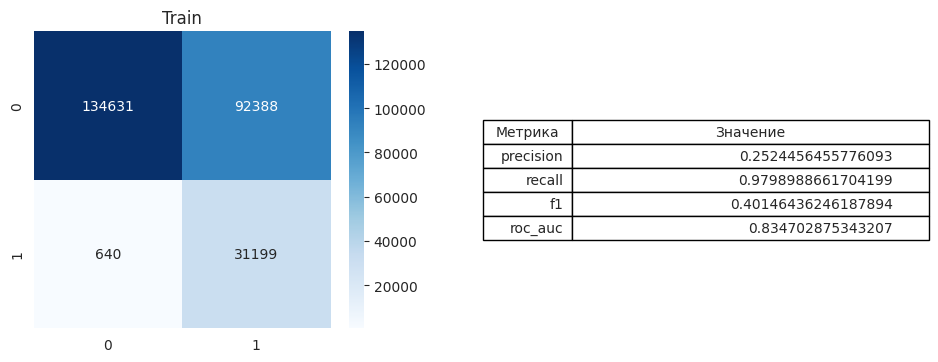


[08:57:49] Запуск: evaluate_model...
Оценка модели LogisticRegressionBaseline:
[08:57:49] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       1.00      0.59      0.74     75673
           1       0.25      0.98      0.40     10613

    accuracy                           0.64     86286
   macro avg       0.62      0.79      0.57     86286
weighted avg       0.90      0.64      0.70     86286

{'precision': 0.252025617388773, 'recall': 0.9788938094789409, 'f1': 0.4008488473039452, 'roc_auc': np.float64(0.8320069008976417)}


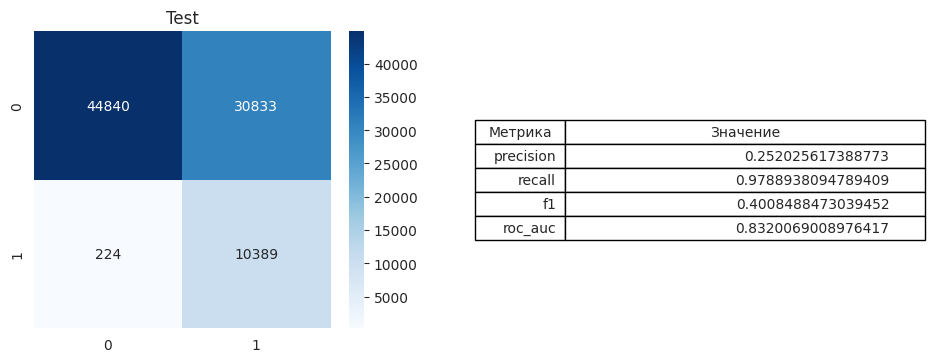

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8347
ROC-AUC на тестовых данных: 0.8320
Разрыв: +0.0027

ХОРОШАЯ ОБОБЩАЮЩАЯ СПОСОБНОСТЬ
• Небольшой разрыв между данными (0.0027)
• Модель хорошо обобщает
      Metric   Train    Test Difference
0  precision  0.2524  0.2520    +0.0004
1     recall  0.9799  0.9789    +0.0010
2         f1  0.4015  0.4008    +0.0006
3    roc_auc  0.8347  0.8320    +0.0027

Время выполнения:
• Обучение: 24.84 сек
• Предсказание: 0.22 сек
[08:57:49] Завершено evaluate через 0:00:00


In [46]:
log_reg_base = LogisticRegressionBaselineModel()

log_reg_base.run_base(X_train, y_train, X_test, y_test)

#### Вывод

Как видно по показателям, основная метрика f1 = 40.11 на тесте. Это отправной показатель, который будем улучшать

<a id="model-compare"></a>
## 3.4. Тестирование и сравнение моделей

### 3.4.1. LogisticRegression

Используем solver='saga' для поддержки early stopping и встроенную поддержку дисбаланса - class_weight='balanced'

In [47]:
class LogisticRegressionModel(ModelFactory):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

        self.param_grid = {
            'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'classifier__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9],
            'classifier__penalty': ['elasticnet', 'l1']
        }

        self._create_pipeline()

    def _create_pipeline(self):
        self.pipeline = Pipeline(
            steps=[
                ("preprocessor", create_preprocessor()),
                ("classifier", LogisticRegression(
                    solver='saga', # SAGA solver supports early stopping
                    class_weight='balanced',
                    l1_ratio=0.5,
                    max_iter=1000,
                    tol=1e-4, # Early stopping tolerance
                    n_jobs=self.n_jobs,
                    random_state=self.random_state,
                    verbose=0
                  )
                ),
            ]
        )

    def _get_optuna_params(self, trial):
        params = {
            'classifier__C': trial.suggest_float('classifier__C', 0.001, 100, log=True),
            'classifier__l1_ratio': trial.suggest_float('classifier__l1_ratio', 0, 1),
            'classifier__penalty': trial.suggest_categorical('classifier__penalty', ['elasticnet', 'l1']),
        }
        return params

In [48]:
log_reg_fixed = LogisticRegressionModel(name="LogisticRegressionFixed")


LogisticRegressionFixed



[08:57:49] Запуск: fit...
Время обучения: 21.45 секунд
[08:58:11] Завершено fit через 0:00:22

[08:58:11] Запуск: predict...
Время предсказания: 0.21 секунд
[08:58:12] Завершено predict через 0:00:00

[08:58:12] Запуск: evaluate...

[08:58:12] Запуск: evaluate_model...
Оценка модели LogisticRegressionFixed:
[08:58:12] Завершено evaluate_model через 0:00:00

Оценка на Train
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    227019
           1       0.25      0.98      0.40     31839

    accuracy                           0.64    258858
   macro avg       0.62      0.79      0.57    258858
weighted avg       0.90      0.64      0.70    258858

{'precision': 0.2524497309544039, 'recall': 0.9798988661704199, 'f1': 0.40146952851554457, 'roc_auc': np.float64(0.8347018270671609)}


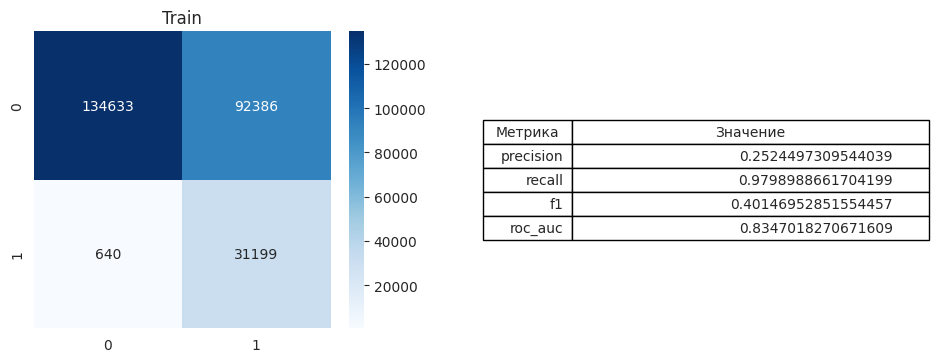


[08:58:12] Запуск: evaluate_model...
Оценка модели LogisticRegressionFixed:
[08:58:12] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       1.00      0.59      0.74     75673
           1       0.25      0.98      0.40     10613

    accuracy                           0.64     86286
   macro avg       0.62      0.79      0.57     86286
weighted avg       0.90      0.64      0.70     86286

{'precision': 0.252025617388773, 'recall': 0.9788938094789409, 'f1': 0.4008488473039452, 'roc_auc': np.float64(0.8320060180878951)}


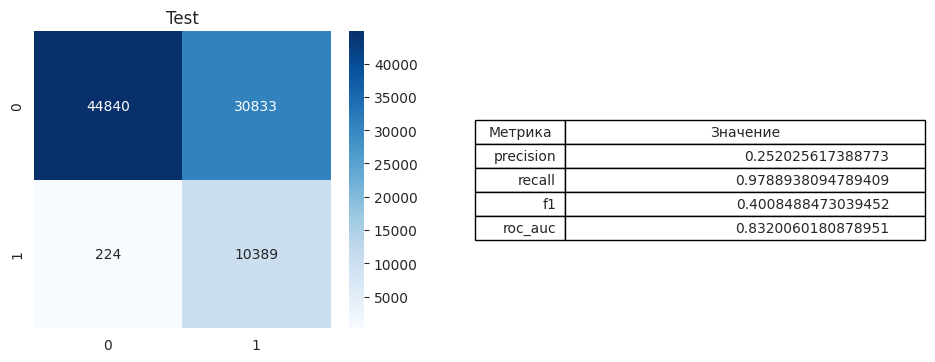

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8347
ROC-AUC на тестовых данных: 0.8320
Разрыв: +0.0027

ХОРОШАЯ ОБОБЩАЮЩАЯ СПОСОБНОСТЬ
• Небольшой разрыв между данными (0.0027)
• Модель хорошо обобщает
      Metric   Train    Test Difference
0  precision  0.2524  0.2520    +0.0004
1     recall  0.9799  0.9789    +0.0010
2         f1  0.4015  0.4008    +0.0006
3    roc_auc  0.8347  0.8320    +0.0027

Время выполнения:
• Обучение: 21.45 сек
• Предсказание: 0.21 сек
[08:58:13] Завершено evaluate через 0:00:00


In [49]:
log_reg_fixed.run_base(X_train, y_train, X_test, y_test)

### 3.4.2. RandomForest

In [50]:
class RandomForestModel(ModelFactory):
    def __init__(self, default_balanced = True, **kwargs):
        self.default_balanced = default_balanced

        super().__init__(**kwargs)

        self.param_grid = {
          'classifier__class_weight': ['balanced'],
          'classifier__n_estimators': [50],
          'classifier__max_depth': [8, 10],
          'classifier__min_samples_leaf': [50, 70],
          'classifier__max_features': ['sqrt', 0.5],
          'classifier__max_samples': [0.1, 0.2],
        }

        self._create_pipeline()

    def _create_pipeline(self):
      class_weight = 'balanced' if self.default_balanced else None

      self.pipeline = Pipeline([
          ("preprocessor", create_preprocessor()),
          ("classifier", RandomForestClassifier(
              random_state=self.random_state,
              n_jobs=self.n_jobs,
              verbose=0,
              class_weight=class_weight,
              bootstrap=True,
              oob_score=True  # Включаем out-of-bag оценку
          ))
      ])

    def _get_optuna_params(self, trial):
      params = {
        'classifier__n_estimators': trial.suggest_int('n_estimators', 50, 100),
        'classifier__max_depth': trial.suggest_int('max_depth', 5, 30),
        'classifier__max_features': trial.suggest_float('max_features', 0.1, 0.9),
        'classifier__max_samples': trial.suggest_float('max_samples', 0.1, 0.5),
        'classifier__class_weight': trial.suggest_categorical('class_weight', [
            'balanced',
        ]),
        'classifier__min_weight_fraction_leaf': trial.suggest_float(
            'min_weight_fraction_leaf', 0.0, 0.5),
      }

      return params

In [51]:
rf_model_fixed = RandomForestModel(name="RandomForestFixed")

RandomForestFixed



[08:58:13] Запуск: fit...
Время обучения: 59.35 секунд
[08:59:25] Завершено fit через 0:01:11

[08:59:25] Запуск: predict...
Время предсказания: 1.88 секунд
[08:59:28] Завершено predict через 0:00:03

[08:59:28] Запуск: evaluate...

[08:59:28] Запуск: evaluate_model...
Оценка модели RandomForestFixed:
[08:59:29] Завершено evaluate_model через 0:00:00

Оценка на Train
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227019
           1       1.00      1.00      1.00     31839

    accuracy                           1.00    258858
   macro avg       1.00      1.00      1.00    258858
weighted avg       1.00      1.00      1.00    258858

{'precision': 0.9970866487062214, 'recall': 0.9996859197839129, 'f1': 0.998384592462477, 'roc_auc': np.float64(0.9999674514922375)}


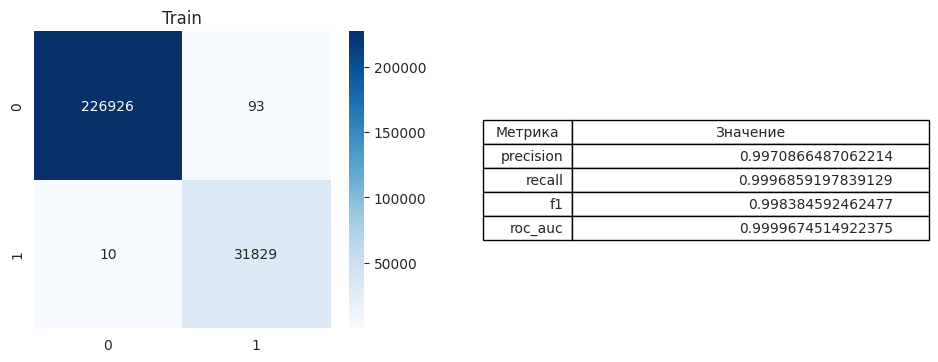


[08:59:29] Запуск: evaluate_model...
Оценка модели RandomForestFixed:
[08:59:29] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     75673
           1       0.39      0.14      0.20     10613

    accuracy                           0.87     86286
   macro avg       0.64      0.55      0.56     86286
weighted avg       0.83      0.87      0.84     86286

{'precision': 0.3897018970189702, 'recall': 0.13549420522001318, 'f1': 0.20107669719639237, 'roc_auc': np.float64(0.8408574060433089)}


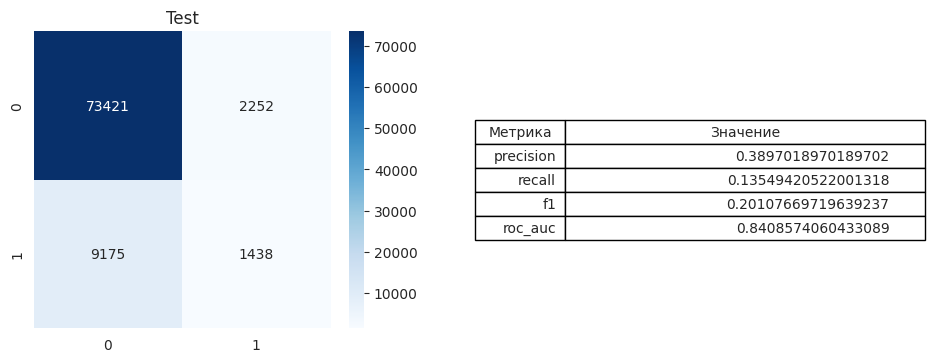

Сравнение train и test

ROC-AUC на тренировочных данных: 1.0000
ROC-AUC на тестовых данных: 0.8409
Разрыв: +0.1591

WARNING!  СИЛЬНОЕ ПЕРЕОБУЧЕНИЕ!
• Высокое качество на тренировочных данных (1.0000)
• Большой разрыв с тестовыми данными (0.1591 > 0.1)
• Рекомендации: увеличьте регуляризацию, уменьшите сложность модели, используйте больше данных
      Metric   Train    Test Difference
0  precision  0.9971  0.3897    +0.6074
1     recall  0.9997  0.1355    +0.8642
2         f1  0.9984  0.2011    +0.7973
3    roc_auc  1.0000  0.8409    +0.1591

Время выполнения:
• Обучение: 59.35 сек
• Предсказание: 1.88 сек
[08:59:29] Завершено evaluate через 0:00:00


In [52]:
rf_model_fixed.run_base(X_train, y_train, X_test, y_test)

### 3.4.3. LightGBM

In [53]:
class LightGBMModel(ModelFactory):
    def __init__(self, default_balanced = True, **kwargs):
        self.default_balanced = default_balanced

        super().__init__(**kwargs)

        self.param_grid = {
            'classifier__n_estimators': [100, 200],
            'classifier__learning_rate': [0.05, 0.1],
            'classifier__max_depth': [5, 7],
            'classifier__num_leaves': [31, 63],
            'classifier__scale_pos_weight': [3, 5],
            'classifier__subsample': [0.8],
            'classifier__colsample_bytree': [0.8],
        }
        self._create_pipeline()

    def _create_pipeline(self):
        class_weight = 'balanced' if self.default_balanced else None

        self.pipeline = Pipeline([
            ("preprocessor", create_preprocessor(skip_encoders=True)),
            ("classifier", LGBMClassifier(
                random_state=self.random_state,
                n_jobs=self.n_jobs,
                verbose=-1,
                # Базовые параметры для несбалансированных данных
                class_weight=class_weight,
                boosting_type='gbdt',
                importance_type='gain',
            ))
        ])

    def _get_optuna_params(self, trial):
        params = {
            'classifier__num_leaves': trial.suggest_int('classifier__num_leaves', 20, 100),
            'classifier__max_depth': trial.suggest_int('classifier__max_depth', 3, 12),
            'classifier__learning_rate': trial.suggest_float('classifier__learning_rate', 0.01, 0.3, log=True),
            'classifier__n_estimators': trial.suggest_int('classifier__n_estimators', 100, 1000),
            'classifier__subsample': trial.suggest_float('classifier__subsample', 0.5, 1.0),
            'classifier__colsample_bytree': trial.suggest_float('classifier__colsample_bytree', 0.5, 1.0),
            'classifier__reg_alpha': trial.suggest_float('classifier__reg_alpha', 0.0, 1.0),
            'classifier__reg_lambda': trial.suggest_float('classifier__reg_lambda', 0.0, 1.0),
            'classifier__scale_pos_weight': trial.suggest_float('classifier__scale_pos_weight', 1, 20),
        }
        return params

In [54]:
light_gbm_fixed = LightGBMModel(name='LightGBMFixed')

LightGBMFixed



[08:59:29] Запуск: fit...
Время обучения: 2.94 секунд
[08:59:36] Завершено fit через 0:00:06

[08:59:36] Запуск: predict...
Время предсказания: 0.82 секунд
[08:59:37] Завершено predict через 0:00:01

[08:59:37] Запуск: evaluate...

[08:59:37] Запуск: evaluate_model...
Оценка модели LightGBMFixed:
[08:59:38] Завершено evaluate_model через 0:00:00

Оценка на Train
              precision    recall  f1-score   support

           0       0.99      0.69      0.81    227019
           1       0.30      0.94      0.45     31839

    accuracy                           0.72    258858
   macro avg       0.64      0.81      0.63    258858
weighted avg       0.90      0.72      0.77    258858

{'precision': 0.29684333902816956, 'recall': 0.9386287257765633, 'f1': 0.45104327811945816, 'roc_auc': np.float64(0.8764889303894416)}


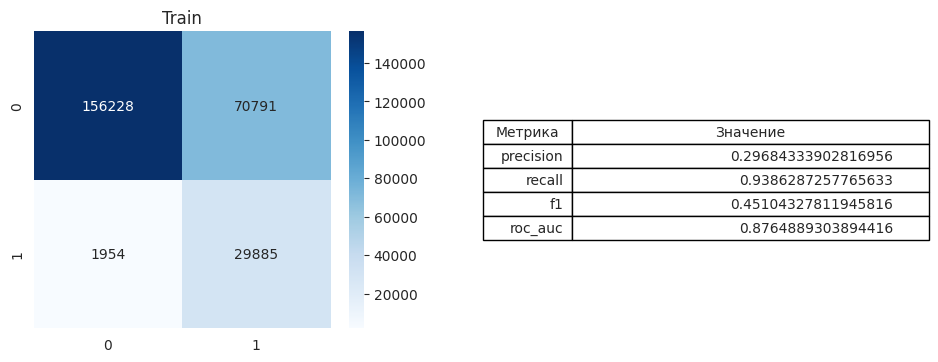


[08:59:38] Запуск: evaluate_model...
Оценка модели LightGBMFixed:
[08:59:38] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       0.98      0.69      0.81     75673
           1       0.29      0.92      0.44     10613

    accuracy                           0.71     86286
   macro avg       0.64      0.80      0.63     86286
weighted avg       0.90      0.71      0.76     86286

{'precision': 0.2914106770056666, 'recall': 0.9206633374163762, 'f1': 0.44269759644790796, 'roc_auc': np.float64(0.8684373444067276)}


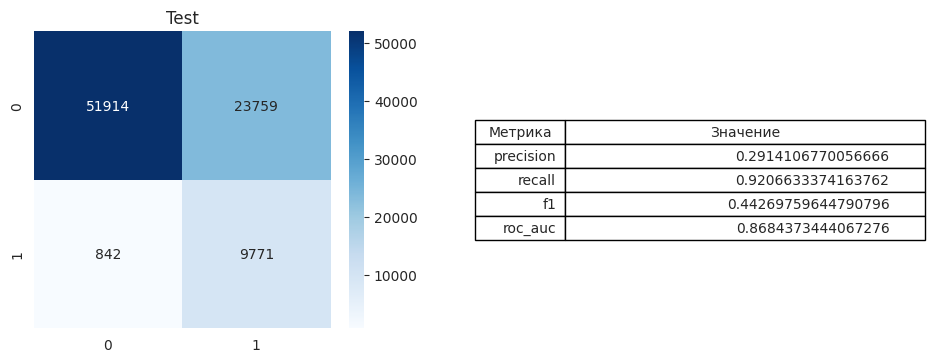

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8765
ROC-AUC на тестовых данных: 0.8684
Разрыв: +0.0081

ХОРОШАЯ ОБОБЩАЮЩАЯ СПОСОБНОСТЬ
• Небольшой разрыв между данными (0.0081)
• Модель хорошо обобщает
      Metric   Train    Test Difference
0  precision  0.2968  0.2914    +0.0054
1     recall  0.9386  0.9207    +0.0180
2         f1  0.4510  0.4427    +0.0083
3    roc_auc  0.8765  0.8684    +0.0081

Время выполнения:
• Обучение: 2.94 сек
• Предсказание: 0.82 сек
[08:59:38] Завершено evaluate через 0:00:00


In [55]:
light_gbm_fixed.run_base(X_train, y_train, X_test, y_test)

### 3.4.4. CatBoost

In [61]:
class CatBoostModel(ModelFactory):
    def __init__(self, default_balanced=True, **kwargs):
        self.default_balanced = default_balanced

        super().__init__(**kwargs)

        self.param_grid = {
            "classifier__iterations": [100, 200],
            "classifier__learning_rate": [0.05, 0.1],
            "classifier__depth": [6, 8],
            "classifier__l2_leaf_reg": [3, 5],
            "classifier__scale_pos_weight": [1, 3],
            "classifier__subsample": [0.8],
        }

        self._create_pipeline()

    def _create_pipeline(self):
        class_weight = "Balanced" if self.default_balanced else None

        self.pipeline = Pipeline(
            [
                ("preprocessor", create_preprocessor(skip_encoders=True)),
                (
                    "classifier",
                    CatBoostClassifier(
                        random_seed=self.random_state,
                        thread_count=self.n_jobs if self.n_jobs != -1 else -1,
                        verbose=0,  # Отключаем вывод по умолчанию
                        allow_writing_files=False,  # Не создавать файлы
                        # Базовые параметры для несбалансированных данных
                        auto_class_weights=class_weight,
                        loss_function="Logloss",
                        eval_metric="F1",
                        # Оптимизации для скорости
                        boosting_type="Plain",  # Plain для скорости, Ordered для качества
                        bootstrap_type="Bernoulli",  # Bernoulli для скорости
                    ),
                ),
            ]
        )

    def _get_optuna_params(self, trial):
        params = {
            "classifier__iterations": trial.suggest_int(
                "classifier__iterations", 100, 200
            ),
            "classifier__learning_rate": trial.suggest_float(
                "classifier__learning_rate", 0.05, 0.1
            ),
            "classifier__depth": trial.suggest_int("classifier__depth", 6, 8),
            "classifier__l2_leaf_reg": trial.suggest_int(
                "classifier__l2_leaf_reg", 3, 5
            ),
            "classifier__scale_pos_weight": trial.suggest_float(
                "classifier__scale_pos_weight", 1, 3
            ),
            "classifier__subsample": 0.8,
            "classifier__colsample_bylevel": trial.suggest_float(
                "classifier__colsample_bylevel", 0.1, 1.0
            ),
            "classifier__random_strength": trial.suggest_float(
                "classifier__random_strength", 0, 10
            ),
            "classifier__border_count": trial.suggest_int(
                "classifier__border_count", 32, 255
            ),
        }

        return params

In [62]:
cat_model_fixed = CatBoostModel(name="CatBoostFixed")

CatBoostFixed



[09:00:33] Запуск: fit...
Время обучения: 72.97 секунд
[09:01:48] Завершено fit через 0:01:15

[09:01:48] Запуск: predict...
Время предсказания: 0.41 секунд
[09:01:49] Завершено predict через 0:00:00

[09:01:49] Запуск: evaluate...

[09:01:49] Запуск: evaluate_model...
Оценка модели CatBoostFixed:
[09:01:49] Завершено evaluate_model через 0:00:00

Оценка на Train
              precision    recall  f1-score   support

           0       0.99      0.71      0.83    227019
           1       0.31      0.94      0.47     31839

    accuracy                           0.74    258858
   macro avg       0.65      0.83      0.65    258858
weighted avg       0.91      0.74      0.78    258858

{'precision': 0.3141531904224646, 'recall': 0.9445020258173937, 'f1': 0.4714846781590273, 'roc_auc': np.float64(0.8920016128990795)}


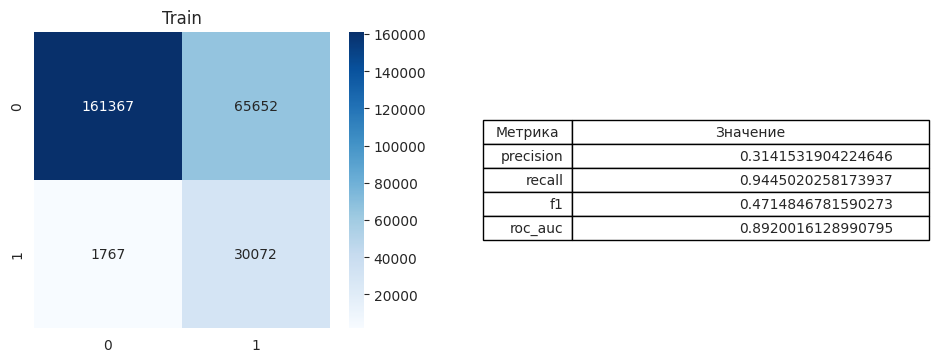


[09:01:49] Запуск: evaluate_model...
Оценка модели CatBoostFixed:
[09:01:49] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       0.98      0.70      0.82     75673
           1       0.30      0.90      0.45     10613

    accuracy                           0.73     86286
   macro avg       0.64      0.80      0.63     86286
weighted avg       0.90      0.73      0.77     86286

{'precision': 0.29970279993743154, 'recall': 0.9026665410345802, 'f1': 0.44999765136925174, 'roc_auc': np.float64(0.8708404720714179)}


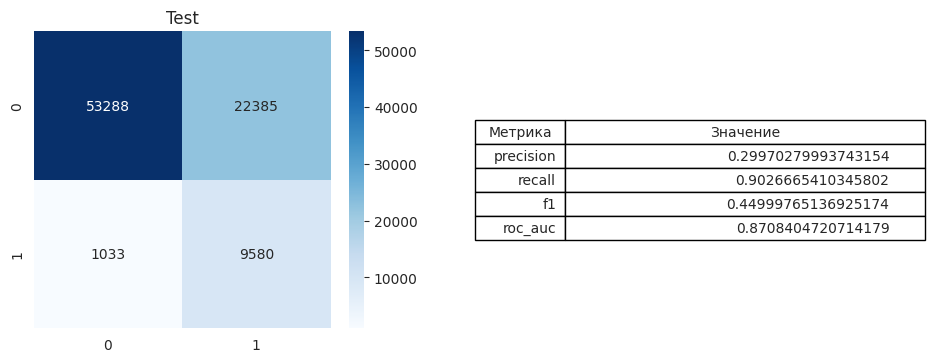

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8920
ROC-AUC на тестовых данных: 0.8708
Разрыв: +0.0212

WARNING!  НЕБОЛЬШОЙ РАЗРЫВ
• Разрыв присутствует, но не критичный (0.0212)
• Рекомендации: мониторинг производительности
      Metric   Train    Test Difference
0  precision  0.3142  0.2997    +0.0145
1     recall  0.9445  0.9027    +0.0418
2         f1  0.4715  0.4500    +0.0215
3    roc_auc  0.8920  0.8708    +0.0212

Время выполнения:
• Обучение: 72.97 сек
• Предсказание: 0.41 сек
[09:01:50] Завершено evaluate через 0:00:00


In [63]:
cat_model_fixed.run_base(X_train, y_train, X_test, y_test)

### 3.4.5. Сравнительная таблица по всем моделям

        Операция  Время (сек)
        fit_time    72.974323
    predict_time     0.414951
grid_search_time          NaN
     optuna_time          NaN
        Операция  Время (сек)
        fit_time     59.35228
    predict_time      1.88290
grid_search_time          NaN
     optuna_time          NaN
        Операция  Время (сек)
        fit_time     2.941082
    predict_time     0.819235
grid_search_time          NaN
     optuna_time          NaN
        Операция  Время (сек)
        fit_time    21.451932
    predict_time     0.211666
grid_search_time          NaN
     optuna_time          NaN


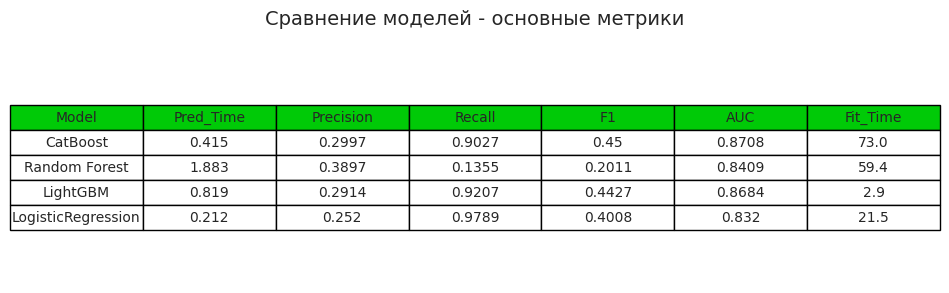

In [89]:
compare_model_metrics([cat_model_fixed, rf_model_fixed, light_gbm_fixed, log_reg_fixed])

Вывод: CatBoost показывает наилучший баланс и самую высокую общую производительность, хотя и требует больше времени на обучение.

## 3.5. Продвинутая гипероптимизация

### 3.5.1. LogisticRegression

#### 3.5.1.1. GridSearch

In [65]:
log_reg_grid = LogisticRegressionModel(name='LogisticRegressionGrid', default_balanced=False)

LogisticRegressionGrid



[09:02:09] Запуск: run_grid...

[09:02:09] Запуск: fit_with_grid_search...
Запуск GridSearchCV...
Fitting 2 folds for each of 60 candidates, totalling 120 fits

Время выполнения GridSearchCV: 1293.12 секунд

Лучшие параметры: {'classifier__C': 100, 'classifier__l1_ratio': 0.1, 'classifier__penalty': 'elasticnet'}
Лучший score (f1): 0.4015
[09:23:43] Завершено fit_with_grid_search через 0:21:34

[09:23:43] Запуск: predict...
Время предсказания: 0.20 секунд
[09:23:43] Завершено predict через 0:00:00

[09:23:43] Запуск: evaluate...

[09:23:43] Запуск: evaluate_model...
Оценка модели LogisticRegressionGrid:
[09:23:43] Завершено evaluate_model через 0:00:00

Оценка на Train
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    227019
           1       0.25      0.98      0.40     31839

    accuracy                           0.64    258858
   macro avg       0.62      0.79      0.57    258858
weighted avg       0.90      0.64      0.70    25

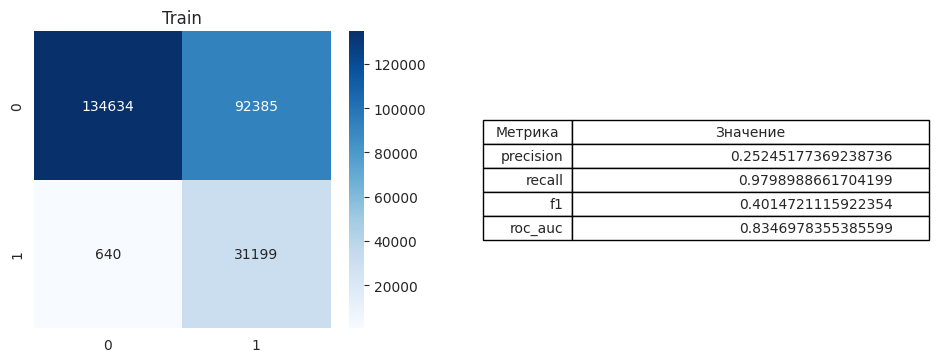


[09:23:44] Запуск: evaluate_model...
Оценка модели LogisticRegressionGrid:
[09:23:44] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       1.00      0.59      0.74     75673
           1       0.25      0.98      0.40     10613

    accuracy                           0.64     86286
   macro avg       0.62      0.79      0.57     86286
weighted avg       0.90      0.64      0.70     86286

{'precision': 0.252025617388773, 'recall': 0.9788938094789409, 'f1': 0.4008488473039452, 'roc_auc': np.float64(0.8320028392257182)}


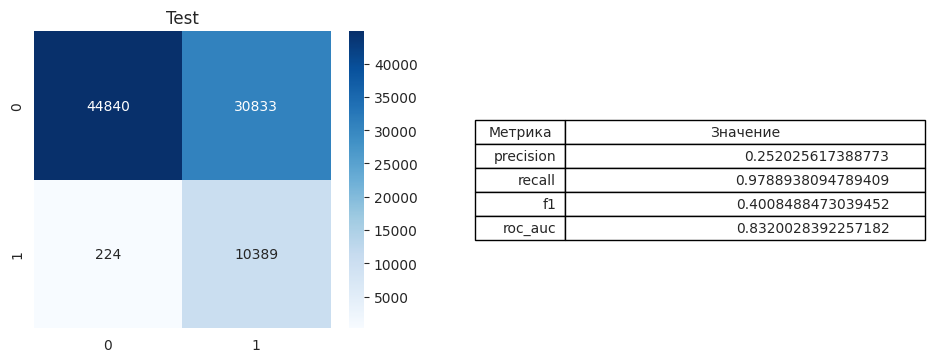

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8347
ROC-AUC на тестовых данных: 0.8320
Разрыв: +0.0027

ХОРОШАЯ ОБОБЩАЮЩАЯ СПОСОБНОСТЬ
• Небольшой разрыв между данными (0.0027)
• Модель хорошо обобщает
      Metric   Train    Test Difference
0  precision  0.2525  0.2520    +0.0004
1     recall  0.9799  0.9789    +0.0010
2         f1  0.4015  0.4008    +0.0006
3    roc_auc  0.8347  0.8320    +0.0027
[09:23:44] Завершено evaluate через 0:00:01
[09:23:44] Завершено run_grid через 0:21:35


In [66]:
log_reg_grid.run_grid(X_train, y_train, X_test, y_test)

#### 3.5.1.2. Optuna

In [67]:
log_reg_optuna = LogisticRegressionModel(name='LogisticRegressionOptuna', default_balanced=False)

LogisticRegressionOptuna


[I 2025-12-27 09:23:44,791] A new study created in memory with name: LogisticRegressionOptuna_optuna



[09:23:44] Запуск: run_optuna...

[09:23:44] Запуск: fit_with_optuna...
Запуск Optuna optimization для LogisticRegressionOptuna...
Количество попыток: 30
Метрика оптимизации: f1


[I 2025-12-27 09:24:18,186] Trial 0 finished with value: 0.40134279373178255 and parameters: {'classifier__C': 0.0745934328572655, 'classifier__l1_ratio': 0.9507143064099162, 'classifier__penalty': 'elasticnet'}. Best is trial 0 with value: 0.40134279373178255.
[I 2025-12-27 09:24:22,839] Trial 1 finished with value: 0.4010883352198874 and parameters: {'classifier__C': 0.006026889128682512, 'classifier__l1_ratio': 0.15599452033620265, 'classifier__penalty': 'l1'}. Best is trial 0 with value: 0.40134279373178255.
[I 2025-12-27 09:25:00,822] Trial 2 finished with value: 0.4014537489645954 and parameters: {'classifier__C': 1.0129197956845732, 'classifier__l1_ratio': 0.7080725777960455, 'classifier__penalty': 'l1'}. Best is trial 2 with value: 0.4014537489645954.
[I 2025-12-27 09:25:41,784] Trial 3 finished with value: 0.40146919403816356 and parameters: {'classifier__C': 14.528246637516036, 'classifier__l1_ratio': 0.21233911067827616, 'classifier__penalty': 'l1'}. Best is trial 3 with val


Время выполнения Optuna: 1046.07 секунд
Среднее время обучения на фолд (лучшая конфигурация): 21.94 секунд

РЕЗУЛЬТАТЫ OPTUNA:
Лучшие параметры (f1):
  classifier__C: 89.31592661919113
  classifier__l1_ratio: 0.40656592772704353
  classifier__penalty: l1
Лучшее значение: 0.4015
{'classifier__C': 89.31592661919113, 'classifier__l1_ratio': 0.40656592772704353, 'classifier__penalty': 'l1'}
[09:41:35] Завершено fit_with_optuna через 0:17:50

[09:41:35] Запуск: predict...
Время предсказания: 0.32 секунд
[09:41:36] Завершено predict через 0:00:00

[09:41:36] Запуск: evaluate...

[09:41:36] Запуск: evaluate_model...
Оценка модели LogisticRegressionOptuna:
[09:41:36] Завершено evaluate_model через 0:00:00

Оценка на Train
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    227019
           1       0.25      0.98      0.40     31839

    accuracy                           0.64    258858
   macro avg       0.62      0.79      0.57    258858
wei

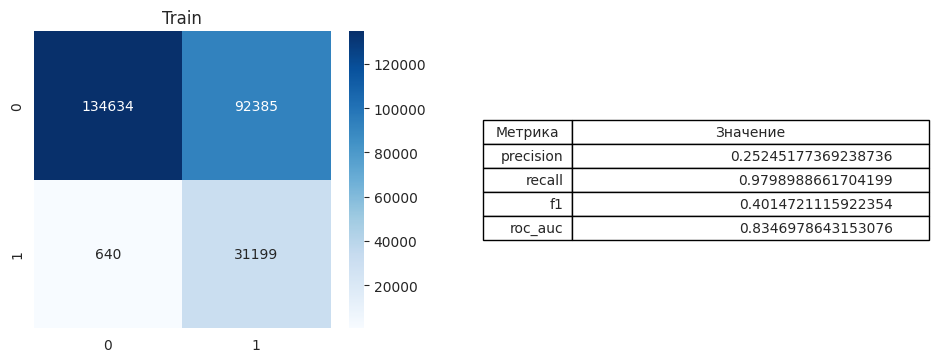


[09:41:36] Запуск: evaluate_model...
Оценка модели LogisticRegressionOptuna:
[09:41:37] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       1.00      0.59      0.74     75673
           1       0.25      0.98      0.40     10613

    accuracy                           0.64     86286
   macro avg       0.62      0.79      0.57     86286
weighted avg       0.90      0.64      0.70     86286

{'precision': 0.252025617388773, 'recall': 0.9788938094789409, 'f1': 0.4008488473039452, 'roc_auc': np.float64(0.8320028728447072)}


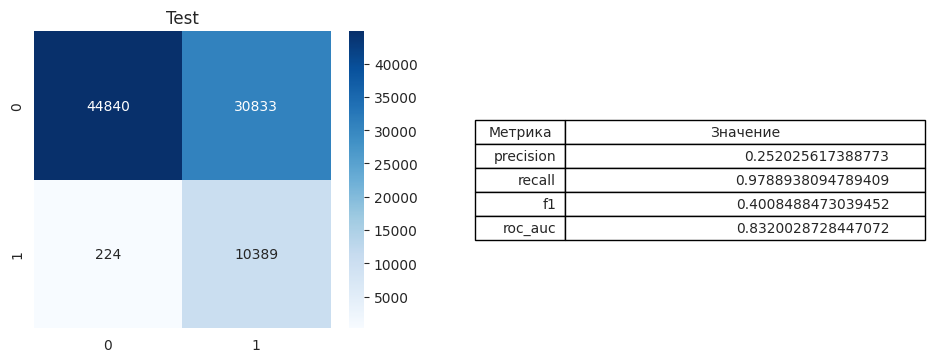

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8347
ROC-AUC на тестовых данных: 0.8320
Разрыв: +0.0027

ХОРОШАЯ ОБОБЩАЮЩАЯ СПОСОБНОСТЬ
• Небольшой разрыв между данными (0.0027)
• Модель хорошо обобщает
      Metric   Train    Test Difference
0  precision  0.2525  0.2520    +0.0004
1     recall  0.9799  0.9789    +0.0010
2         f1  0.4015  0.4008    +0.0006
3    roc_auc  0.8347  0.8320    +0.0027
[09:41:37] Завершено evaluate через 0:00:01
[09:41:37] Завершено run_optuna через 0:17:52


In [68]:
log_reg_optuna.run_optuna(X_train, y_train, X_test, y_test)

### 3.5.2. RandomForest

#### 3.5.2.1. RandomForest GridSearch

In [69]:
rf_grid = RandomForestModel(name='RandomForestGrid', default_balanced=False)

RandomForestGrid



[09:41:37] Запуск: run_grid...

[09:41:37] Запуск: fit_with_grid_search...
Запуск GridSearchCV...
Fitting 2 folds for each of 16 candidates, totalling 32 fits

Время выполнения GridSearchCV: 130.25 секунд

Лучшие параметры: {'classifier__class_weight': 'balanced', 'classifier__max_depth': 10, 'classifier__max_features': 0.5, 'classifier__max_samples': 0.1, 'classifier__min_samples_leaf': 50, 'classifier__n_estimators': 50}
Лучший score (f1): 0.4410
[09:43:50] Завершено fit_with_grid_search через 0:02:12

[09:43:50] Запуск: predict...
Время предсказания: 0.40 секунд
[09:43:50] Завершено predict через 0:00:00

[09:43:50] Запуск: evaluate...

[09:43:50] Запуск: evaluate_model...
Оценка модели RandomForestGrid:
[09:43:51] Завершено evaluate_model через 0:00:00

Оценка на Train
              precision    recall  f1-score   support

           0       0.98      0.68      0.81    227019
           1       0.29      0.92      0.44     31839

    accuracy                           0.71    2588

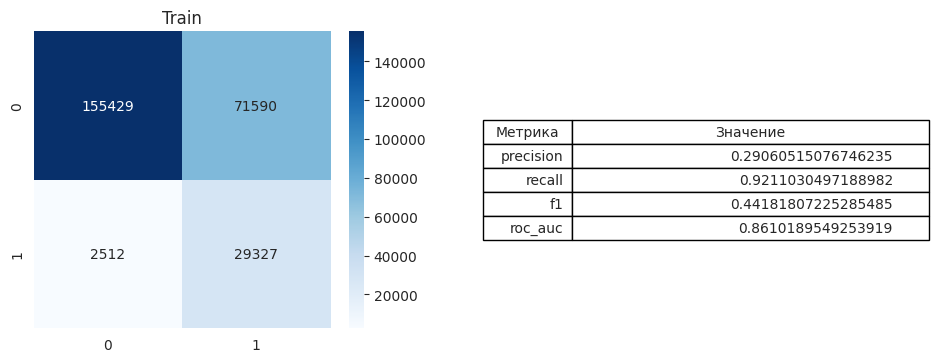


[09:43:51] Запуск: evaluate_model...
Оценка модели RandomForestGrid:
[09:43:51] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       0.98      0.68      0.81     75673
           1       0.29      0.91      0.44     10613

    accuracy                           0.71     86286
   macro avg       0.64      0.80      0.62     86286
weighted avg       0.90      0.71      0.76     86286

{'precision': 0.2880640076142887, 'recall': 0.9125600678413267, 'f1': 0.43789844915675724, 'roc_auc': np.float64(0.857457141681759)}


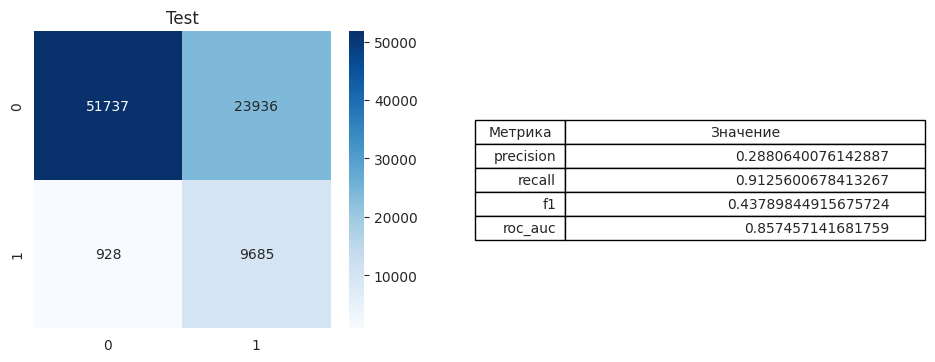

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8610
ROC-AUC на тестовых данных: 0.8575
Разрыв: +0.0036

ХОРОШАЯ ОБОБЩАЮЩАЯ СПОСОБНОСТЬ
• Небольшой разрыв между данными (0.0036)
• Модель хорошо обобщает
      Metric   Train    Test Difference
0  precision  0.2906  0.2881    +0.0025
1     recall  0.9211  0.9126    +0.0085
2         f1  0.4418  0.4379    +0.0039
3    roc_auc  0.8610  0.8575    +0.0036
[09:43:51] Завершено evaluate через 0:00:00
[09:43:51] Завершено run_grid через 0:02:14


In [70]:
rf_grid.run_grid(X_train, y_train, X_test, y_test)

#### 3.5.2.2. RandomForest Optuna

In [71]:
rf_optuna = RandomForestModel(name='RandomForestOptuna', default_balanced=False)

RandomForestOptuna


[I 2025-12-27 09:43:51,746] A new study created in memory with name: RandomForestOptuna_optuna



[09:43:51] Запуск: run_optuna...

[09:43:51] Запуск: fit_with_optuna...
Запуск Optuna optimization для RandomForestOptuna...
Количество попыток: 30
Метрика оптимизации: f1


[I 2025-12-27 09:44:01,871] Trial 0 finished with value: 0.43197519927988043 and parameters: {'n_estimators': 69, 'max_depth': 29, 'max_features': 0.685595153449124, 'max_samples': 0.3394633936788146, 'class_weight': 'balanced', 'min_weight_fraction_leaf': 0.07800932022121826}. Best is trial 0 with value: 0.43197519927988043.
[I 2025-12-27 09:44:07,732] Trial 1 finished with value: 0.2954690255967912 and parameters: {'n_estimators': 57, 'max_depth': 6, 'max_features': 0.7929409166199481, 'max_samples': 0.34044600469728353, 'class_weight': 'balanced', 'min_weight_fraction_leaf': 0.35403628889802274}. Best is trial 0 with value: 0.43197519927988043.
[I 2025-12-27 09:44:13,305] Trial 2 finished with value: 0.4311181045237654 and parameters: {'n_estimators': 51, 'max_depth': 30, 'max_features': 0.7659541126403374, 'max_samples': 0.18493564427131048, 'class_weight': 'balanced', 'min_weight_fraction_leaf': 0.09091248360355031}. Best is trial 0 with value: 0.43197519927988043.
[I 2025-12-27 0


Время выполнения Optuna: 276.18 секунд
Среднее время обучения на фолд (лучшая конфигурация): 13.55 секунд

РЕЗУЛЬТАТЫ OPTUNA:
Лучшие параметры (f1):
  n_estimators: 100
  max_depth: 20
  max_features: 0.8243485696443329
  max_samples: 0.4276254514166099
  class_weight: balanced
  min_weight_fraction_leaf: 0.00388166687789892
Лучшее значение: 0.4373
{'classifier__n_estimators': 100, 'classifier__max_depth': 20, 'classifier__max_features': 0.8243485696443329, 'classifier__max_samples': 0.4276254514166099, 'classifier__class_weight': 'balanced', 'classifier__min_weight_fraction_leaf': 0.00388166687789892}
[09:49:08] Завершено fit_with_optuna через 0:05:16

[09:49:08] Запуск: predict...
Время предсказания: 0.66 секунд
[09:49:09] Завершено predict через 0:00:01

[09:49:09] Запуск: evaluate...

[09:49:09] Запуск: evaluate_model...
Оценка модели RandomForestOptuna:
[09:49:09] Завершено evaluate_model через 0:00:00

Оценка на Train
              precision    recall  f1-score   support

      

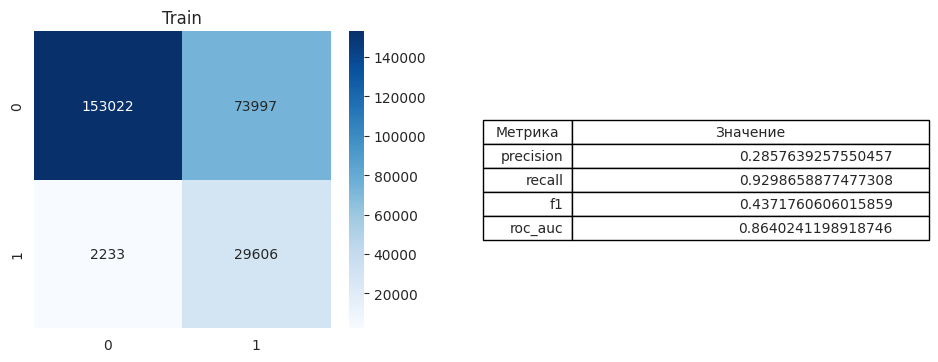


[09:49:09] Запуск: evaluate_model...
Оценка модели RandomForestOptuna:
[09:49:09] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       0.98      0.67      0.80     75673
           1       0.28      0.92      0.43     10613

    accuracy                           0.70     86286
   macro avg       0.63      0.80      0.62     86286
weighted avg       0.90      0.70      0.75     86286

{'precision': 0.2837763413432273, 'recall': 0.9224535946480731, 'f1': 0.4340308565348466, 'roc_auc': np.float64(0.8589599546902691)}


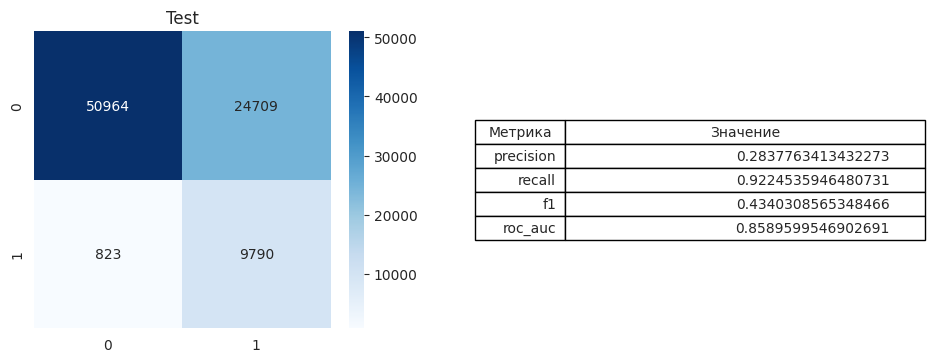

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8640
ROC-AUC на тестовых данных: 0.8590
Разрыв: +0.0051

ХОРОШАЯ ОБОБЩАЮЩАЯ СПОСОБНОСТЬ
• Небольшой разрыв между данными (0.0051)
• Модель хорошо обобщает
      Metric   Train    Test Difference
0  precision  0.2858  0.2838    +0.0020
1     recall  0.9299  0.9225    +0.0074
2         f1  0.4372  0.4340    +0.0031
3    roc_auc  0.8640  0.8590    +0.0051
[09:49:10] Завершено evaluate через 0:00:00
[09:49:10] Завершено run_optuna через 0:05:18


In [72]:
rf_optuna.run_optuna(X_train, y_train, X_test, y_test)

### 3.5.3. LightGBM

#### 3.5.3.1. LightGBM GridSearch

In [73]:
light_gbm_grid = LightGBMModel(name='LightGBMGrid', default_balanced=False)

LightGBMGrid



[09:49:10] Запуск: run_grid...

[09:49:10] Запуск: fit_with_grid_search...
Запуск GridSearchCV...
Fitting 2 folds for each of 32 candidates, totalling 64 fits

Время выполнения GridSearchCV: 590.18 секунд

Лучшие параметры: {'classifier__colsample_bytree': 0.8, 'classifier__learning_rate': 0.05, 'classifier__max_depth': 7, 'classifier__n_estimators': 200, 'classifier__num_leaves': 63, 'classifier__scale_pos_weight': 3, 'classifier__subsample': 0.8}
Лучший score (f1): 0.4769
[09:59:07] Завершено fit_with_grid_search через 0:09:57

[09:59:07] Запуск: predict...
Время предсказания: 0.93 секунд
[09:59:09] Завершено predict через 0:00:02

[09:59:09] Запуск: evaluate...

[09:59:09] Запуск: evaluate_model...
Оценка модели LightGBMGrid:
[09:59:09] Завершено evaluate_model через 0:00:00

Оценка на Train
              precision    recall  f1-score   support

           0       0.96      0.83      0.89    227019
           1       0.37      0.74      0.50     31839

    accuracy                 

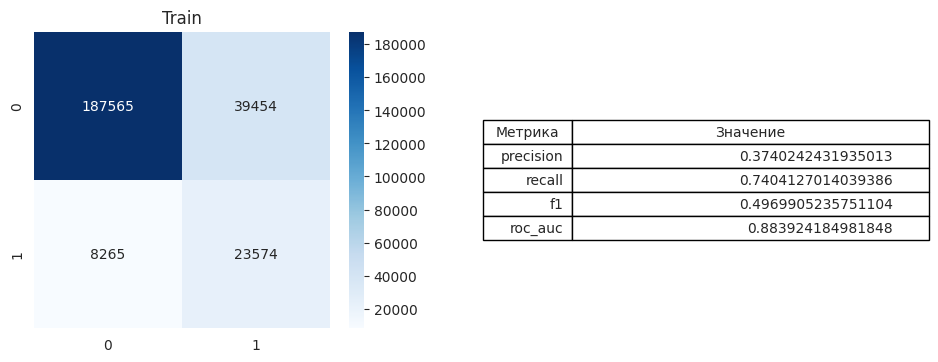


[09:59:10] Запуск: evaluate_model...
Оценка модели LightGBMGrid:
[09:59:10] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       0.95      0.82      0.88     75673
           1       0.36      0.71      0.47     10613

    accuracy                           0.81     86286
   macro avg       0.65      0.76      0.68     86286
weighted avg       0.88      0.81      0.83     86286

{'precision': 0.35613520166635104, 'recall': 0.7088476396871761, 'f1': 0.4740838768629675, 'roc_auc': np.float64(0.8706877260628756)}


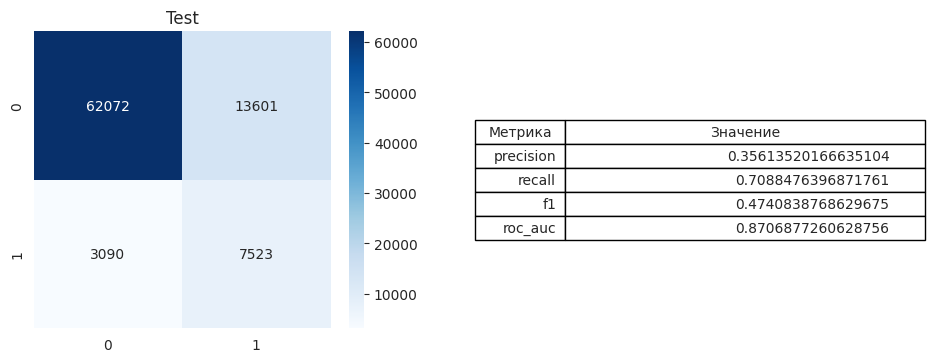

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8839
ROC-AUC на тестовых данных: 0.8707
Разрыв: +0.0132

ХОРОШАЯ ОБОБЩАЮЩАЯ СПОСОБНОСТЬ
• Небольшой разрыв между данными (0.0132)
• Модель хорошо обобщает
      Metric   Train    Test Difference
0  precision  0.3740  0.3561    +0.0179
1     recall  0.7404  0.7088    +0.0316
2         f1  0.4970  0.4741    +0.0229
3    roc_auc  0.8839  0.8707    +0.0132
[09:59:11] Завершено evaluate через 0:00:01
[09:59:11] Завершено run_grid через 0:10:00


In [74]:
light_gbm_grid.run_grid(X_train, y_train, X_test, y_test)

#### 3.5.3.2. LightGBM Optuna

In [75]:
light_gbm_optuna = LightGBMModel(name='LightGBMOptuna', default_balanced=False)

LightGBMOptuna


[I 2025-12-27 09:59:11,186] A new study created in memory with name: LightGBMOptuna_optuna



[09:59:11] Запуск: run_optuna...

[09:59:11] Запуск: fit_with_optuna...
Запуск Optuna optimization для LightGBMOptuna...
Количество попыток: 30
Метрика оптимизации: f1


[I 2025-12-27 10:00:20,154] Trial 0 finished with value: 0.4501966824093723 and parameters: {'classifier__num_leaves': 50, 'classifier__max_depth': 12, 'classifier__learning_rate': 0.1205712628744377, 'classifier__n_estimators': 639, 'classifier__subsample': 0.5780093202212182, 'classifier__colsample_bytree': 0.5779972601681014, 'classifier__reg_alpha': 0.05808361216819946, 'classifier__reg_lambda': 0.8661761457749352, 'classifier__scale_pos_weight': 12.421185223120967}. Best is trial 0 with value: 0.4501966824093723.
[I 2025-12-27 10:00:48,427] Trial 1 finished with value: 0.4402374047563222 and parameters: {'classifier__num_leaves': 77, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2708160864249968, 'classifier__n_estimators': 850, 'classifier__subsample': 0.6061695553391381, 'classifier__colsample_bytree': 0.5909124836035503, 'classifier__reg_alpha': 0.18340450985343382, 'classifier__reg_lambda': 0.3042422429595377, 'classifier__scale_pos_weight': 10.97037220101252}. Be


Время выполнения Optuna: 677.03 секунд
Среднее время обучения на фолд (лучшая конфигурация): 11.49 секунд

РЕЗУЛЬТАТЫ OPTUNA:
Лучшие параметры (f1):
  classifier__num_leaves: 98
  classifier__max_depth: 9
  classifier__learning_rate: 0.017023810747318804
  classifier__n_estimators: 753
  classifier__subsample: 0.9233625854586776
  classifier__colsample_bytree: 0.9398069633632562
  classifier__reg_alpha: 0.1565772322629042
  classifier__reg_lambda: 0.35805661012144113
  classifier__scale_pos_weight: 3.5183751581022755
Лучшее значение: 0.4751
{'classifier__num_leaves': 98, 'classifier__max_depth': 9, 'classifier__learning_rate': 0.017023810747318804, 'classifier__n_estimators': 753, 'classifier__subsample': 0.9233625854586776, 'classifier__colsample_bytree': 0.9398069633632562, 'classifier__reg_alpha': 0.1565772322629042, 'classifier__reg_lambda': 0.35805661012144113, 'classifier__scale_pos_weight': 3.5183751581022755}
[10:11:31] Завершено fit_with_optuna через 0:12:20

[10:11:31] Запус

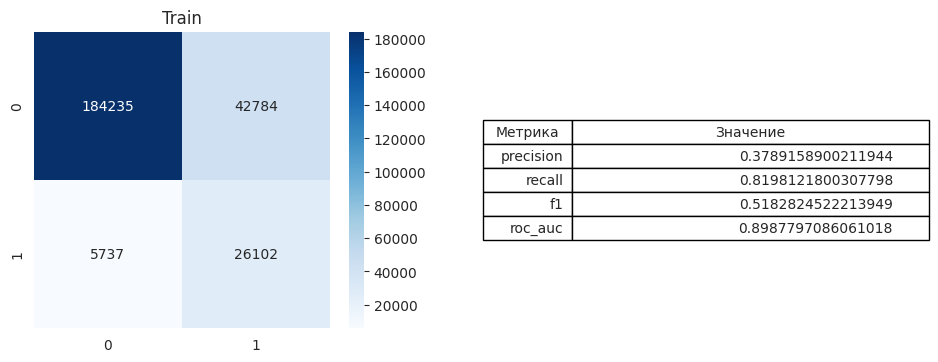


[10:11:45] Запуск: evaluate_model...
Оценка модели LightGBMOptuna:
[10:11:46] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       0.96      0.80      0.87     75673
           1       0.35      0.75      0.48     10613

    accuracy                           0.80     86286
   macro avg       0.65      0.78      0.67     86286
weighted avg       0.88      0.80      0.82     86286

{'precision': 0.3477085422753238, 'recall': 0.7513426929237728, 'f1': 0.47540690395278123, 'roc_auc': np.float64(0.8713163245795293)}


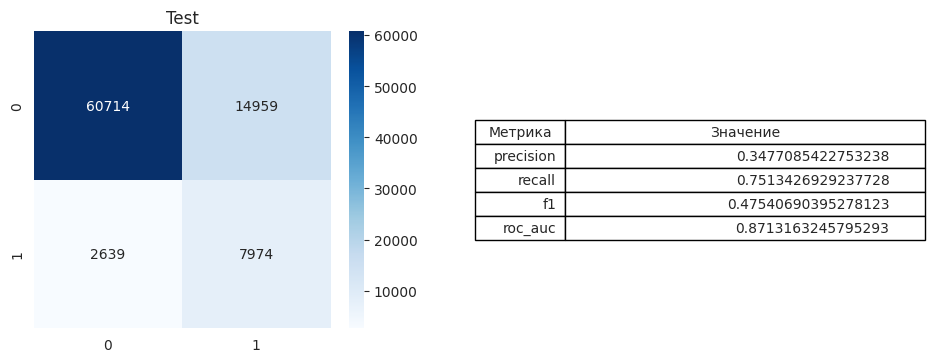

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8988
ROC-AUC на тестовых данных: 0.8713
Разрыв: +0.0275

WARNING!  НЕБОЛЬШОЙ РАЗРЫВ
• Разрыв присутствует, но не критичный (0.0275)
• Рекомендации: мониторинг производительности
      Metric   Train    Test Difference
0  precision  0.3789  0.3477    +0.0312
1     recall  0.8198  0.7513    +0.0685
2         f1  0.5183  0.4754    +0.0429
3    roc_auc  0.8988  0.8713    +0.0275
[10:11:47] Завершено evaluate через 0:00:01
[10:11:47] Завершено run_optuna через 0:12:35


In [76]:
light_gbm_optuna.run_optuna(X_train, y_train, X_test, y_test)

### 3.5.4. CatBoost

#### 3.5.4.1. CatBoost GridSearch

In [77]:
catboost_grid = CatBoostModel(name='CatBoostGrid', default_balanced=False)

CatBoostGrid



[10:11:47] Запуск: run_grid...

[10:11:47] Запуск: fit_with_grid_search...
Запуск GridSearchCV...
Fitting 2 folds for each of 32 candidates, totalling 64 fits

Время выполнения GridSearchCV: 480.58 секунд

Лучшие параметры: {'classifier__depth': 6, 'classifier__iterations': 200, 'classifier__l2_leaf_reg': 5, 'classifier__learning_rate': 0.1, 'classifier__scale_pos_weight': 3, 'classifier__subsample': 0.8}
Лучший score (f1): 0.4709
[10:19:49] Завершено fit_with_grid_search через 0:08:02

[10:19:49] Запуск: predict...
Время предсказания: 0.32 секунд
[10:19:50] Завершено predict через 0:00:00

[10:19:50] Запуск: evaluate...

[10:19:50] Запуск: evaluate_model...
Оценка модели CatBoostGrid:
[10:19:50] Завершено evaluate_model через 0:00:00

Оценка на Train
              precision    recall  f1-score   support

           0       0.96      0.81      0.88    227019
           1       0.36      0.73      0.48     31839

    accuracy                           0.80    258858
   macro avg       

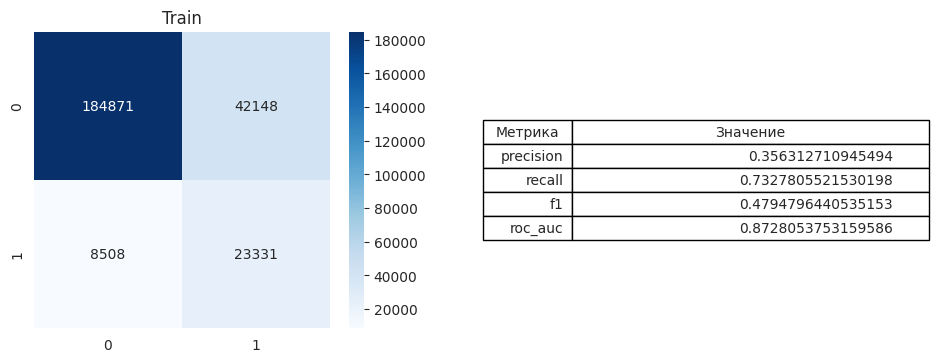


[10:19:51] Запуск: evaluate_model...
Оценка модели CatBoostGrid:
[10:19:51] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       0.95      0.81      0.88     75673
           1       0.35      0.72      0.47     10613

    accuracy                           0.80     86286
   macro avg       0.65      0.77      0.67     86286
weighted avg       0.88      0.80      0.83     86286

{'precision': 0.3479250091008373, 'recall': 0.7204371996607933, 'f1': 0.4692380864708951, 'roc_auc': np.float64(0.8677321213659596)}


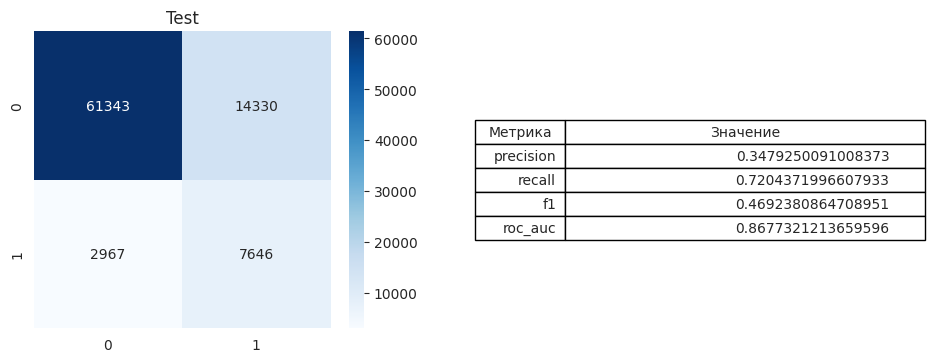

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8728
ROC-AUC на тестовых данных: 0.8677
Разрыв: +0.0051

ХОРОШАЯ ОБОБЩАЮЩАЯ СПОСОБНОСТЬ
• Небольшой разрыв между данными (0.0051)
• Модель хорошо обобщает
      Metric   Train    Test Difference
0  precision  0.3563  0.3479    +0.0084
1     recall  0.7328  0.7204    +0.0123
2         f1  0.4795  0.4692    +0.0102
3    roc_auc  0.8728  0.8677    +0.0051
[10:19:51] Завершено evaluate через 0:00:01
[10:19:51] Завершено run_grid через 0:08:04


In [78]:
catboost_grid.run_grid(X_train, y_train, X_test, y_test)

#### 3.5.4.2. CatBoost Optuna

In [79]:
catboost_optuna = CatBoostModel(name='CatBoostOptuna', default_balanced=False)

CatBoostOptuna


[I 2025-12-27 10:19:51,594] A new study created in memory with name: CatBoostOptuna_optuna



[10:19:51] Запуск: run_optuna...

[10:19:51] Запуск: fit_with_optuna...
Запуск Optuna optimization для CatBoostOptuna...
Количество попыток: 30
Метрика оптимизации: f1


[I 2025-12-27 10:19:59,105] Trial 0 finished with value: 0.09181516242771653 and parameters: {'classifier__iterations': 137, 'classifier__learning_rate': 0.09753571532049582, 'classifier__depth': 8, 'classifier__l2_leaf_reg': 4, 'classifier__scale_pos_weight': 1.312037280884873, 'classifier__colsample_bylevel': 0.2403950683025824, 'classifier__random_strength': 0.5808361216819946, 'classifier__border_count': 226}. Best is trial 0 with value: 0.09181516242771653.
[I 2025-12-27 10:20:08,248] Trial 1 finished with value: 0.4564686530946751 and parameters: {'classifier__iterations': 160, 'classifier__learning_rate': 0.08540362888980227, 'classifier__depth': 6, 'classifier__l2_leaf_reg': 5, 'classifier__scale_pos_weight': 2.6648852816008435, 'classifier__colsample_bylevel': 0.29110519961044856, 'classifier__random_strength': 1.8182496720710062, 'classifier__border_count': 73}. Best is trial 1 with value: 0.4564686530946751.
[I 2025-12-27 10:20:15,175] Trial 2 finished with value: 0.41730007


Время выполнения Optuna: 227.21 секунд
Среднее время обучения на фолд (лучшая конфигурация): 4.49 секунд

РЕЗУЛЬТАТЫ OPTUNA:
Лучшие параметры (f1):
  classifier__iterations: 171
  classifier__learning_rate: 0.06439694378125348
  classifier__depth: 7
  classifier__l2_leaf_reg: 4
  classifier__scale_pos_weight: 2.966658829058813
  classifier__colsample_bylevel: 0.5350507509284778
  classifier__random_strength: 0.2317976866851252
  classifier__border_count: 202
Лучшее значение: 0.4673
{'classifier__iterations': 171, 'classifier__learning_rate': 0.06439694378125348, 'classifier__depth': 7, 'classifier__l2_leaf_reg': 4, 'classifier__scale_pos_weight': 2.966658829058813, 'classifier__colsample_bylevel': 0.5350507509284778, 'classifier__random_strength': 0.2317976866851252, 'classifier__border_count': 202}
[10:23:49] Завершено fit_with_optuna через 0:03:57

[10:23:49] Запуск: predict...
Время предсказания: 0.31 секунд
[10:23:49] Завершено predict через 0:00:00

[10:23:49] Запуск: evaluate...

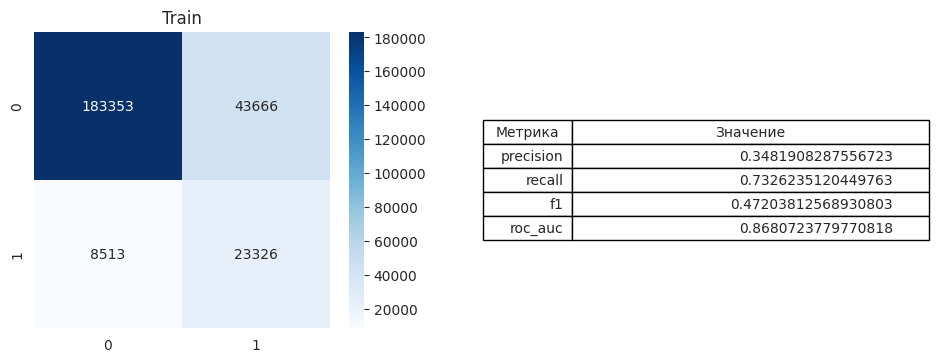


[10:23:50] Запуск: evaluate_model...
Оценка модели CatBoostOptuna:
[10:23:50] Завершено evaluate_model через 0:00:00

Оценка на Test
              precision    recall  f1-score   support

           0       0.95      0.81      0.87     75673
           1       0.34      0.72      0.46     10613

    accuracy                           0.80     86286
   macro avg       0.65      0.76      0.67     86286
weighted avg       0.88      0.80      0.82     86286

{'precision': 0.3426451526393421, 'recall': 0.7223216809573165, 'f1': 0.46480324986357846, 'roc_auc': np.float64(0.8642500582439645)}


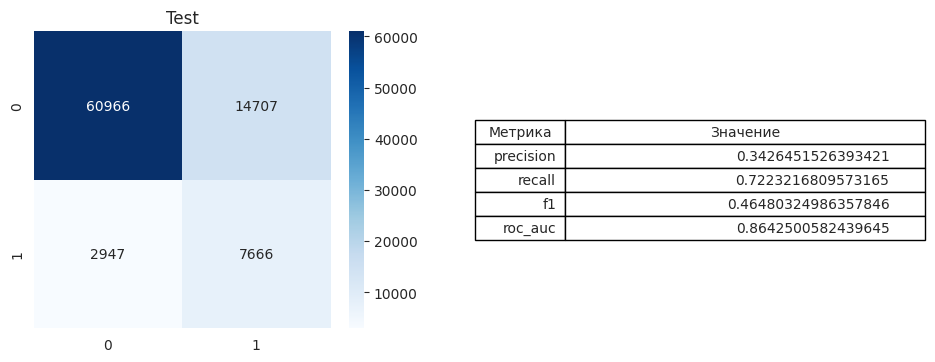

Сравнение train и test

ROC-AUC на тренировочных данных: 0.8681
ROC-AUC на тестовых данных: 0.8643
Разрыв: +0.0038

ХОРОШАЯ ОБОБЩАЮЩАЯ СПОСОБНОСТЬ
• Небольшой разрыв между данными (0.0038)
• Модель хорошо обобщает
      Metric   Train    Test Difference
0  precision  0.3482  0.3426    +0.0055
1     recall  0.7326  0.7223    +0.0103
2         f1  0.4720  0.4648    +0.0072
3    roc_auc  0.8681  0.8643    +0.0038
[10:23:50] Завершено evaluate через 0:00:00
[10:23:50] Завершено run_optuna через 0:03:59


In [80]:
catboost_optuna.run_optuna(X_train, y_train, X_test, y_test)

<a id="model-compare-time"></a>
## 3.6. Анализ компромисса “Качество vs. Сложность”

        Операция  Время (сек)
        fit_time          NaN
    predict_time     0.316043
grid_search_time   480.578985
     optuna_time          NaN
        Операция  Время (сек)
        fit_time          NaN
    predict_time     0.404563
grid_search_time   130.249709
     optuna_time          NaN
        Операция  Время (сек)
        fit_time          NaN
    predict_time     0.927875
grid_search_time   590.175130
     optuna_time          NaN
        Операция  Время (сек)
        fit_time          NaN
    predict_time     0.204795
grid_search_time  1293.123871
     optuna_time          NaN


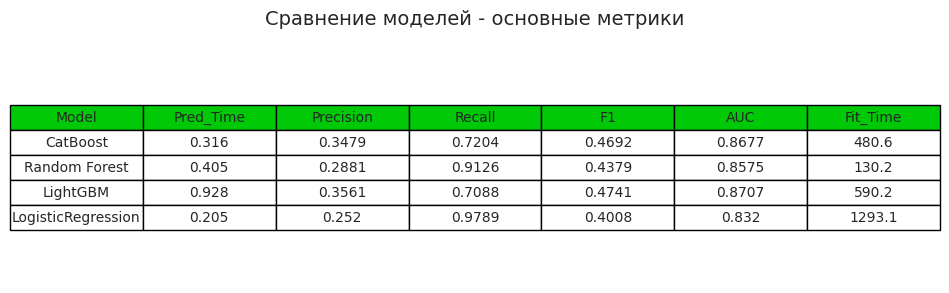

In [94]:
compare_model_metrics([catboost_grid, rf_grid, light_gbm_grid, log_reg_grid], is_grid=True)

        Операция  Время (сек)
        fit_time          NaN
    predict_time     0.306081
grid_search_time          NaN
     optuna_time   227.208423
        Операция  Время (сек)
        fit_time          NaN
    predict_time     0.662436
grid_search_time          NaN
     optuna_time   276.184035
        Операция  Время (сек)
        fit_time          NaN
    predict_time     6.164327
grid_search_time          NaN
     optuna_time   677.030892
        Операция  Время (сек)
        fit_time          NaN
    predict_time     0.322158
grid_search_time          NaN
     optuna_time  1046.074302


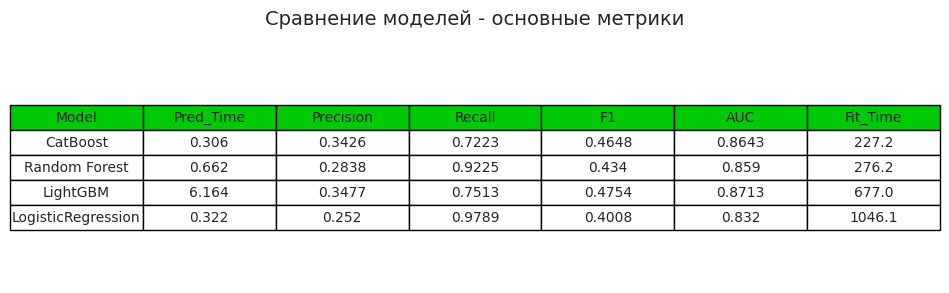

In [108]:
compare_model_metrics([catboost_optuna, rf_optuna, light_gbm_optuna, log_reg_optuna], is_optuna=True)

<a id="model-fi"></a>
### 3.6.1. Feature Importance

In [103]:
def get_catboost_feature_importances():
  importances = catboost_optuna.pipeline.named_steps['classifier'].get_feature_importance()
  feature_names = X_train.columns

  feat_imp = pd.DataFrame({'feature': feature_names, 'importance': importances})
  feat_imp = feat_imp.sort_values('importance', ascending=False)

  print(feat_imp.head(10))

  feat_imp.to_csv('catboost_best_feature_importances.csv', index=False)

  plt.figure(figsize=(10, 6))
  plt.barh(feat_imp['feature'][:10][::-1], feat_imp['importance'][:10][::-1])
  plt.xlabel('Feature Importance')
  plt.title('Top 10 Feature Importances (CatBoost)')
  plt.tight_layout()
  plt.show()


                feature  importance
7        Annual_Premium   50.261055
8  Policy_Sales_Channel   19.974669
1                   Age    9.518129
9               Vintage    7.120586
2       Driving_License    4.737750
3           Region_Code    3.238089
6        Vehicle_Damage    2.547758
0                Gender    1.657596
4    Previously_Insured    0.892360
5           Vehicle_Age    0.052009


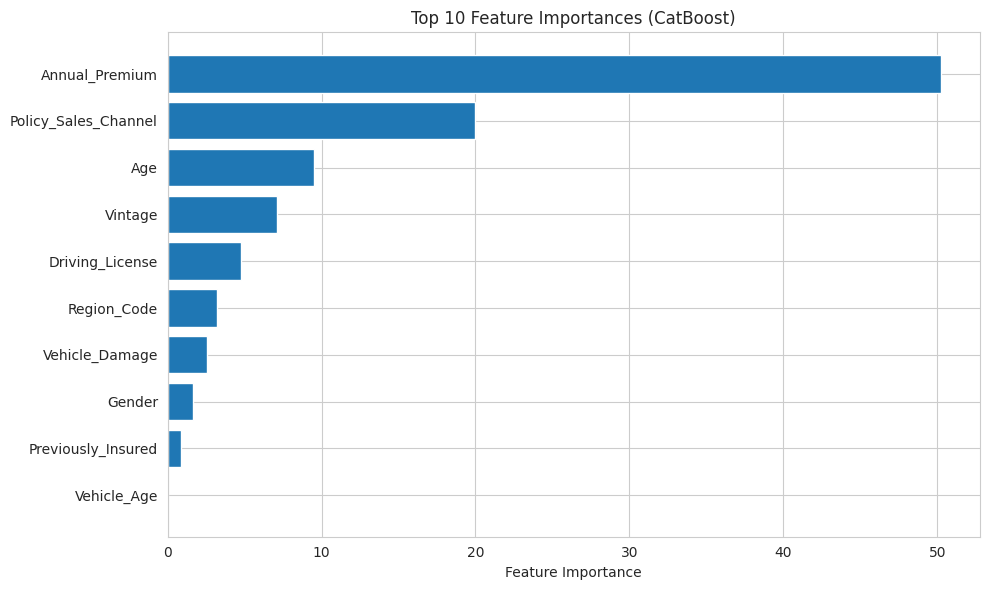

In [104]:
get_catboost_feature_importances()

<a id="best-model-to-do"></a>
# 4. Things to be done

1. Поресерчить и попробовать другие техники борьбы с дисбалансом
2. Попробовать другие наборы параметров для подбора для гиперпараметров
3. Еще оптимизировать скорость для больших данных
4. В данном датасете не было ни дубликатов ни пропусков, добавить предобработку данных если появятся новые данные где будут дубликаты и/или пропуски
5. Имитировать ситуацию с дополнением новых данных и протестировать предобработчик пропусков
6. Доработать существующие и добавить другие методы для конструктора моделей (например, применения feature importance, feature engineering, удаление данных по итогам feature importance)
7. Найти потенциально полезные признаки для feature engineering, которые дадут прирост качеству